In [2]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import copy
from jupyterthemes import jtplot
jtplot.style()
from matplotlib import rc
rc('font',**{'family':'Nimbus Mono PS'})
rc('text',color = '#f9e076')
rc('axes',labelcolor = '#ff8300')
rc('xtick',color = '#ff8300')
rc('ytick',color = '#ff8300')
np.random.seed(42)

# Fetch the data

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
mnist_X_all, mnist_y_all = mnist["data"].to_numpy(), mnist["target"].to_numpy().astype(np.uint8) 
print(mnist_X_all.shape)
print(mnist_y_all.shape)

(70000, 784)
(70000,)


# Helper function to show data

In [5]:
def Show_MNIST_digits(X, **kwargs):
     
    start_index = 0
    randomize = False
    show_labels = False
    label_delimiter = ''
    rows = 5
    cols = 10
    seed = 42
    y = np.array([])
    y2 = np.array([])
    
    for key, value in kwargs.items():
        if key == 'randomize':
            randomize = value
        elif key == 'start_index':
            start_index = value
        elif key == 'show_labels':
            show_labels = value
        elif key == 'label_delimiter':
            label_delimiter = value
        elif key == 'y':
            y = value
        elif key == 'y2':
            y2 = value
        elif key == 'rows':
            rows = value
        elif key == 'cols':
            cols = value
        elif key == 'seed':
            seed = value
    
    # Fix the seed
    np.random.seed(seed)
    
    # Generate index array
    if randomize:
        indices = np.random.randint(0, high = X.shape[0], size = (rows, cols))
    else:
        indices = np.arange(start_index, start_index + rows * cols).reshape((rows, cols))

    # Initialize plot dimensions   
    fig, ax = plt.subplots(nrows = rows, ncols = cols, figsize = (cols, rows * 1.2), squeeze = False)
    
    # create the colormap
    binary_with_green_bg = copy.copy(plt.cm.binary)
    binary_with_green_bg.set_bad('#39ff14', 1.0)

    for i in range (0, rows):
        for j in range (0, cols):
            # Get X and y from index
            digit = X[indices[i , j]]
            # reshape to a square image
            digit_image = digit.reshape(28, 28)
            digit_image_masked = np.ma.masked_where(digit_image == 0.0, digit_image)
            # show image
            ax[i][j].imshow(digit_image_masked, cmap = binary_with_green_bg, interpolation="antialiased")
            ax[i][j].get_xaxis().set_ticks([])
            ax[i][j].get_yaxis().set_visible(False)
            # show the digit as the x label
            if show_labels:
                ax[i][j].set_xlabel(str(y[indices[i , j]]) + (',' + str(y2[indices[i , j]]) if y2.shape == y.shape else '') + label_delimiter)

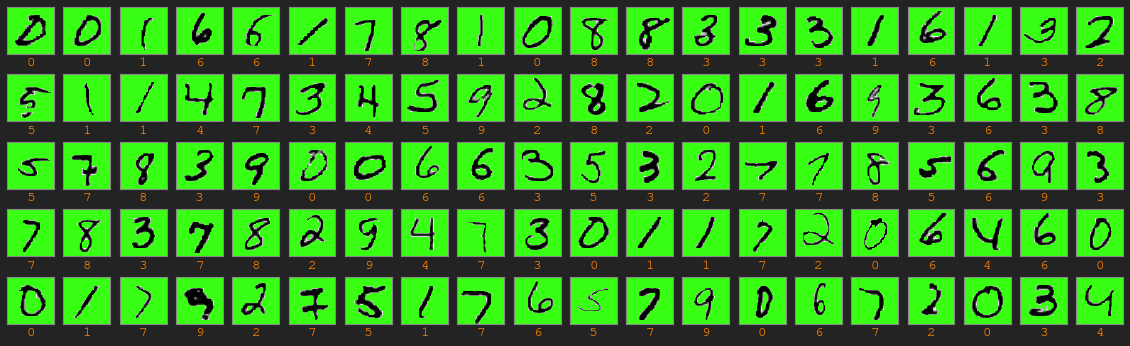

In [6]:
Show_MNIST_digits(mnist_X_all, y = mnist_y_all, cols = 20, randomize = True, show_labels = True)

# Create train, test, val sets using a stratified split

In [7]:
from sklearn.model_selection import train_test_split
# separate into training and test set
mnist_X_train, mnist_X_test, mnist_y_train, mnist_y_test = train_test_split(
    mnist_X_all, mnist_y_all, stratify = mnist_y_all, train_size = 6.0 / 7.0, random_state = 42)

In [8]:
# Check distribution of digits in various sets
unique_elements, counts_elements_train = np.unique(mnist_y_train, return_counts = True)
unique_elements, counts_elements_all = np.unique(mnist_y_all, return_counts = True)
counts_train_all = np.c_[counts_elements_train, counts_elements_all]
counts_sum = np.sum(counts_train_all, axis = 0 , keepdims = True)
counts_normalized = counts_train_all / counts_sum
# display as a pandas dataframe
value_cols = ['Train','All']
df = pd.DataFrame(counts_normalized, columns = value_cols)
df.insert(0, 'Digit', unique_elements.astype(np.uint8))
df.style.hide_index().format('{:.2%}', subset = value_cols)

Digit,Train,All
0,9.86%,9.86%
1,11.25%,11.25%
2,9.98%,9.99%
3,10.20%,10.20%
4,9.75%,9.75%
5,9.02%,9.02%
6,9.82%,9.82%
7,10.42%,10.42%
8,9.75%,9.75%
9,9.94%,9.94%


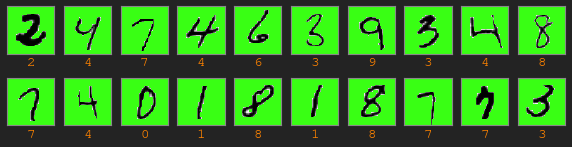

In [9]:
Show_MNIST_digits(mnist_X_train, y = mnist_y_train, rows = 2, show_labels = True, randomize = True)

# Training Utilities

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from mpl_toolkits.axes_grid1 import make_axes_locatable

def show_metrics(y, y_pred, title = '', show_confmx = False):
    conf_mx = confusion_matrix(y, y_pred)

    # plot 3 flavors of the confusion matrix
    fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 5))
    
    # Heatmap
    im = ax[0].matshow(conf_mx, cmap = plt.cm.jet)   
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = fig.colorbar(im, cax = cax, orientation='vertical')
    ax[0].set_title('HeatMap')
    # Grayscale
    im = ax[1].matshow(conf_mx, cmap = plt.cm.gray)
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = fig.colorbar(im, cax = cax, orientation='vertical')
    ax[1].set_title('Grayscale')
    # Normalized
    row_sum = conf_mx.sum(axis = 1, keepdims = True)
    conf_mx_norm = conf_mx / row_sum
    np.fill_diagonal(conf_mx_norm, 0)
    im = ax[2].matshow(conf_mx_norm, cmap = plt.cm.hot)
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = fig.colorbar(im, cax = cax, orientation='vertical')
    ax[2].set_title('Normalized (diag 0)')
    
    for i in range(0, 3):
        ax[i].set_xticks(range(0, 10))
        ax[i].set_yticks(range(0, 10))
        ax[i].set_xlabel('Predicted')
        ax[i].set_ylabel('Actual')
    
    plt.suptitle(title + '\n' + 
                 'Accuracy = ' + str(accuracy_score(y, y_pred)) + '\n' + 
                 'F1 score = ' + str(f1_score(y, y_pred, average = 'micro')))
    
    plt.tight_layout()
    plt.subplots_adjust(top = 3.0)
    plt.show()
    
    if show_confmx:
        print('\nconfusion matrix = \n', conf_mx)

In [43]:
# A function to extract only the probability of the predicted label
def proba_predicted(y, y_proba, **kwargs):
    percent = True
    for key, value in kwargs.items():
        if key == 'percent':
            percent = value
            
    # Using the predicted labes to extract the corresponding probabilities
    y_label_proba = y_proba[range(y_proba.shape[0]), y]
    
    if percent:
        y_label_proba = (y_label_proba * 100).astype(np.uint8)
    else:
        y_label_proba = np.round(y_label_proba, 2)
        
    return y_label_proba

# CLF 1 - Random Forest Classifier

In [82]:
from sklearn.ensemble import RandomForestClassifier

In [91]:
# Random Cross Validation search for best Classifier
rndf_clf = RandomForestClassifier(n_jobs = -1, random_state = 42)
parameters = {
    'n_estimators': range(455, 500),
    'max_depth' : range(14, 15),
    'min_samples_leaf': range(10, 20)
}
rndf_rcv = RandomizedSearchCV(rndf_clf, param_distributions = parameters, 
                              n_iter = 6, cv = 2, scoring = 'accuracy', 
                              verbose = 3, random_state = 42)
rndf_rcv.fit(mnist_X_train, mnist_y_train)
rndf_rcv.best_estimator_

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END max_depth=14, min_samples_leaf=19, n_estimators=457; total time=  30.0s
[CV 2/2] END max_depth=14, min_samples_leaf=19, n_estimators=457; total time=  29.9s
[CV 1/2] END max_depth=14, min_samples_leaf=19, n_estimators=494; total time=  32.2s
[CV 2/2] END max_depth=14, min_samples_leaf=19, n_estimators=494; total time=  32.5s
[CV 1/2] END max_depth=14, min_samples_leaf=12, n_estimators=482; total time=  32.2s
[CV 2/2] END max_depth=14, min_samples_leaf=12, n_estimators=482; total time=  32.4s
[CV 1/2] END max_depth=14, min_samples_leaf=10, n_estimators=485; total time=  32.9s
[CV 2/2] END max_depth=14, min_samples_leaf=10, n_estimators=485; total time=  33.1s
[CV 1/2] END max_depth=14, min_samples_leaf=19, n_estimators=465; total time=  30.7s
[CV 2/2] END max_depth=14, min_samples_leaf=19, n_estimators=465; total time=  30.8s
[CV 1/2] END max_depth=14, min_samples_leaf=13, n_estimators=477; total time=  32.2s
[CV 2

RandomForestClassifier(max_depth=14, min_samples_leaf=10, n_estimators=485,
                       n_jobs=-1, random_state=42)

In [92]:
# Fit the best classifier
rndf_clf_best = RandomForestClassifier(max_depth=15, n_estimators=500,
                       n_jobs=-1, random_state=42)
%time rndf_clf_best.fit(mnist_X_train, mnist_y_train)
rndf_clf_best

CPU times: user 5min 5s, sys: 867 ms, total: 5min 6s
Wall time: 42.3 s


RandomForestClassifier(max_depth=15, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [93]:
# Predict on training set
mnist_y_train_rndf_pred = rndf_clf_best.predict(mnist_X_train)
# Predict on test set
mnist_y_test_rndf_pred = rndf_clf_best.predict(mnist_X_test)

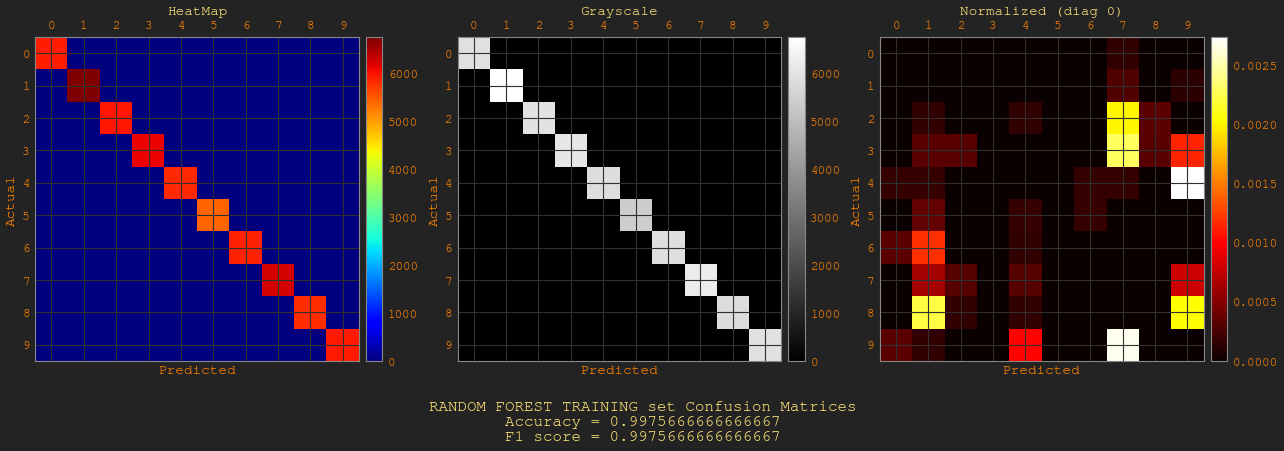

In [94]:
# Random Forest Training Evaluation
show_metrics(mnist_y_train, mnist_y_train_rndf_pred, 'RANDOM FOREST TRAINING set Confusion Matrices')

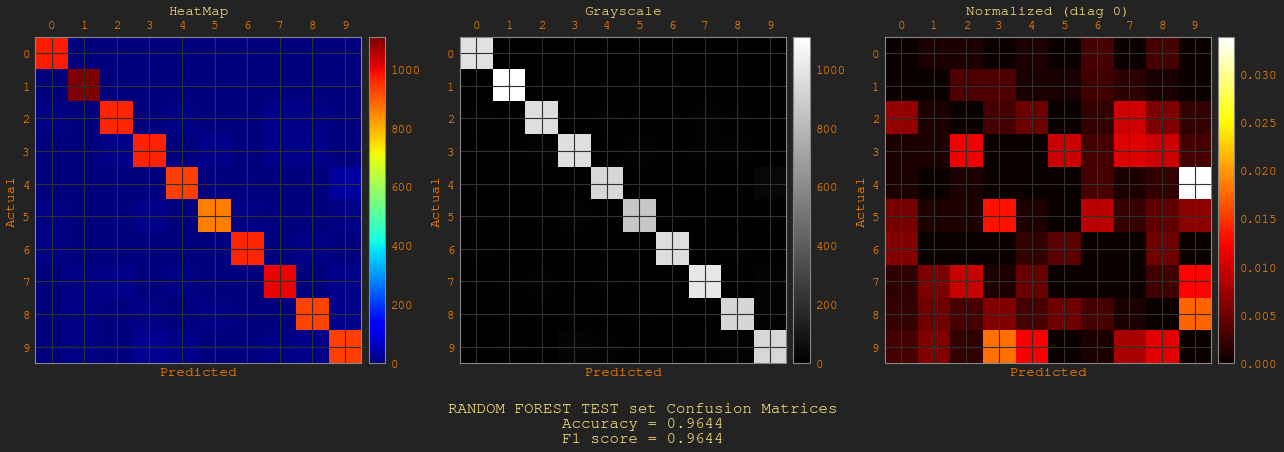

In [95]:
# Random Forest Test Evaluation
show_metrics(mnist_y_test, mnist_y_test_rndf_pred, 'RANDOM FOREST TEST set Confusion Matrices')

# Feature Importance from Random Forest

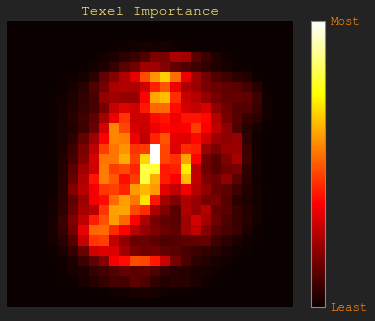

In [105]:
rndf_feature_importance = rndf_clf_best.feature_importances_
fig, ax = plt.subplots()

plt.imshow(rndf_feature_importance.reshape(28, 28), cmap = plt.get_cmap('hot'), interpolation="none")
cbar = plt.colorbar(orientation='vertical', shrink = 0.94)
cbar.set_ticks([0.0, np.max(rndf_feature_importance)])
cbar.set_ticklabels(['Least', 'Most']) 
plt.title('Texel Importance')

plt.axis('off')
plt.show()

# Data Prep plus Feature selection

In [112]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureSelectorByThreshold(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, cutoff = 0.0001):
        self.feature_importances = feature_importances
        self.cutoff = cutoff
    def fit(self, X, y=None):
        self.feature_mask_ = np.ma.masked_where(self.feature_importances <= self.cutoff, self.feature_importances)
        return self
    def transform(self, X):
        return X[:, ~self.feature_mask_.mask]

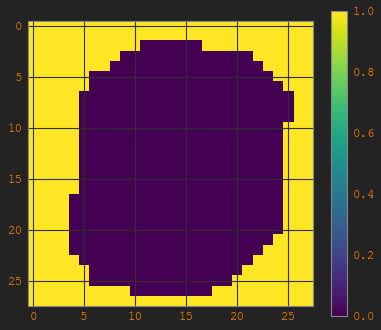

(60000, 451)

In [113]:
f_selectr = FeatureSelectorByThreshold(rndf_feature_importance)
mnist_X_train_f_slct_test = f_selectr.fit_transform(mnist_X_train)
plt.imshow(f_selectr.feature_mask_.mask.reshape(28, 28))
plt.colorbar()
plt.show()
mnist_X_train_f_slct_test.shape

Nice! Was able to cut down features by nearly half!!

In [114]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
prep_and_select_pipeline = Pipeline([
                            ('FeatureSelector', FeatureSelectorByThreshold(rndf_feature_importance)),
                            ('scaler', StandardScaler())])

In [115]:
mnist_X_train_prepped = prep_and_select_pipeline.fit_transform(mnist_X_train)
mnist_X_test_prepped = prep_and_select_pipeline.transform(mnist_X_test)

# CLF 2 - Extra Forest Classifier

In [56]:
from sklearn.ensemble import ExtraTreesClassifier

In [163]:
# Random Cross Validation search for best Classifier
ext_clf = ExtraTreesClassifier(random_state = 0, n_jobs=-1)

parameters = {
    'n_estimators': range(100, 600),
    'max_depth' : range(5, 20),
    'min_samples_leaf': range(100, 2000),
    'max_leaf_nodes' : range(50, 1000)
}
ext_rcv = RandomizedSearchCV(ext_clf, param_distributions = parameters, 
                              n_iter = 50, cv = 2, scoring = 'accuracy', 
                              verbose = 3, random_state = 42)
ext_rcv.fit(mnist_X_train, mnist_y_train)
ext_rcv.best_estimator_

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV 1/2] END max_depth=18, max_leaf_nodes=343, min_samples_leaf=521, n_estimators=259; total time=   9.1s
[CV 2/2] END max_depth=18, max_leaf_nodes=343, min_samples_leaf=521, n_estimators=259; total time=   8.3s
[CV 1/2] END max_depth=5, max_leaf_nodes=879, min_samples_leaf=692, n_estimators=514; total time=  14.9s
[CV 2/2] END max_depth=5, max_leaf_nodes=879, min_samples_leaf=692, n_estimators=514; total time=  14.4s
[CV 1/2] END max_depth=18, max_leaf_nodes=267, min_samples_leaf=163, n_estimators=527; total time=  22.3s
[CV 2/2] END max_depth=18, max_leaf_nodes=267, min_samples_leaf=163, n_estimators=527; total time=  22.8s
[CV 1/2] END max_depth=7, max_leaf_nodes=848, min_samples_leaf=803, n_estimators=524; total time=  14.9s
[CV 2/2] END max_depth=7, max_leaf_nodes=848, min_samples_leaf=803, n_estimators=524; total time=  15.5s
[CV 1/2] END max_depth=16, max_leaf_nodes=657, min_samples_leaf=1343, n_estimators=305; total 

[CV 2/2] END max_depth=11, max_leaf_nodes=904, min_samples_leaf=793, n_estimators=171; total time=   6.7s
[CV 1/2] END max_depth=11, max_leaf_nodes=657, min_samples_leaf=1049, n_estimators=217; total time=   8.1s
[CV 2/2] END max_depth=11, max_leaf_nodes=657, min_samples_leaf=1049, n_estimators=217; total time=   7.2s
[CV 1/2] END max_depth=14, max_leaf_nodes=210, min_samples_leaf=973, n_estimators=403; total time=  13.4s
[CV 2/2] END max_depth=14, max_leaf_nodes=210, min_samples_leaf=973, n_estimators=403; total time=  14.1s
[CV 1/2] END max_depth=13, max_leaf_nodes=259, min_samples_leaf=153, n_estimators=334; total time=  17.1s
[CV 2/2] END max_depth=13, max_leaf_nodes=259, min_samples_leaf=153, n_estimators=334; total time=  17.5s
[CV 1/2] END max_depth=16, max_leaf_nodes=996, min_samples_leaf=1501, n_estimators=331; total time=   9.1s
[CV 2/2] END max_depth=16, max_leaf_nodes=996, min_samples_leaf=1501, n_estimators=331; total time=   9.7s
[CV 1/2] END max_depth=9, max_leaf_nodes=5

ExtraTreesClassifier(max_depth=14, max_leaf_nodes=602, min_samples_leaf=114,
                     n_estimators=253, n_jobs=-1, random_state=0)

In [37]:
# Fit the best classifier
ext_clf_best = ExtraTreesClassifier(max_depth = 14, max_leaf_nodes = 602, min_samples_leaf = 114,
                     n_estimators = 253, n_jobs = -1, random_state = 0)
ext_clf_best.fit(mnist_X_train_prepped, mnist_y_train)

ExtraTreesClassifier(max_depth=14, max_leaf_nodes=602, min_samples_leaf=114,
                     n_estimators=253, n_jobs=-1, random_state=0)

In [38]:
# Predict on training set
mnist_y_train_ext_pred = ext_clf_best.predict(mnist_X_train_prepped)
mnist_y_train_ext_proba = ext_clf_best.predict_proba(mnist_X_train_prepped)
mnist_y_train_ext_max_proba = proba_predicted(mnist_y_train_ext_pred, 
                                              mnist_y_train_ext_proba)

# Predict on validation set
mnist_y_val_ext_pred = ext_clf_best.predict(mnist_X_val_prepped)
mnist_y_val_ext_proba = ext_clf_best.predict_proba(mnist_X_val_prepped)
mnist_y_val_ext_max_proba = proba_predicted(mnist_y_val_ext_pred, 
                                            mnist_y_val_ext_proba)

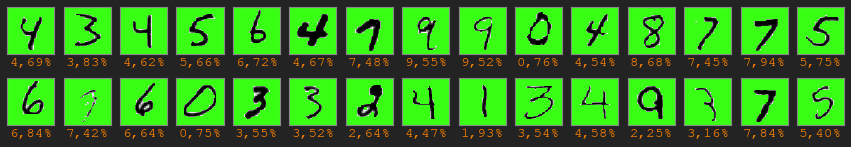

In [39]:
# Show some random validation predictions with probability
Show_MNIST_digits(mnist_X_val, y = mnist_y_val_ext_pred, 
                y2 = mnist_y_val_ext_max_proba, rows = 2, cols = 15, 
                show_labels = True, label_delimiter = '%')

Note how the correctly predicted labels generally have higher probability!

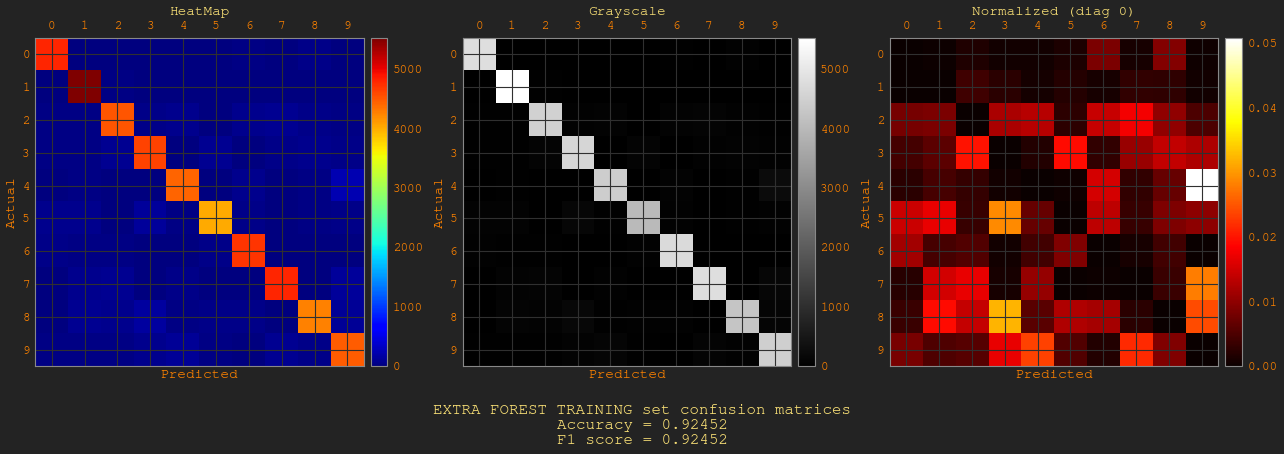

In [98]:
# Extra Forest Training Evaluation
show_metrics(mnist_y_train, mnist_y_train_ext_pred, 'EXTRA FOREST TRAINING set confusion matrices')

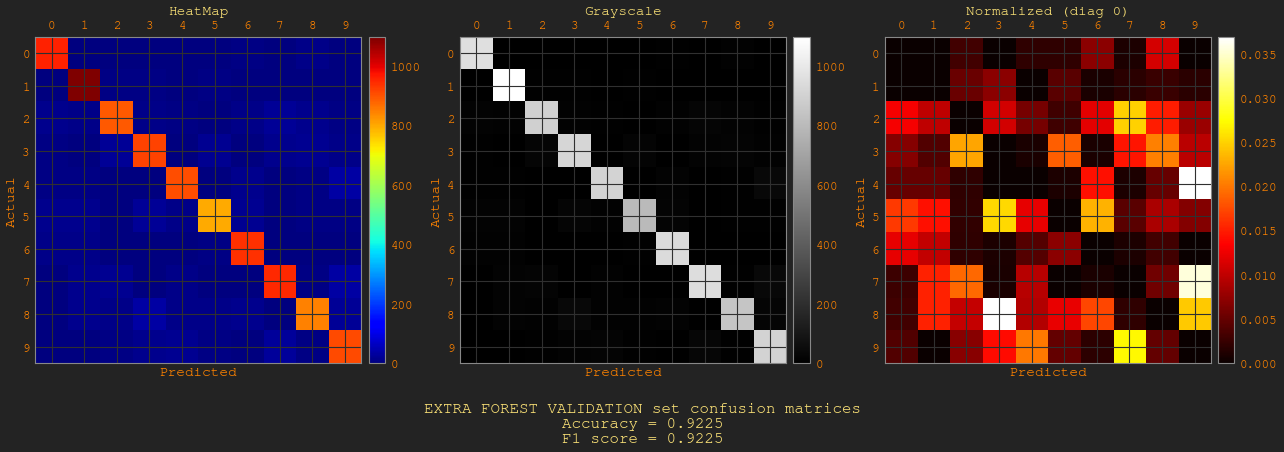

In [99]:
# Extra Forest Validation Evaluation
show_metrics(mnist_y_val, mnist_y_val_ext_pred, 'EXTRA FOREST VALIDATION set confusion matrices')

# Some missclassified digits

In [42]:
mnist_X_val_ext_missclassified = mnist_X_val[mnist_y_val != mnist_y_val_ext_pred]
mnist_y_val_ext_missclassified = mnist_y_val_ext_pred[mnist_y_val != mnist_y_val_ext_pred]
mnist_y_val_ext_misclsfd_proba = mnist_y_val_ext_max_proba[mnist_y_val != mnist_y_val_ext_pred]

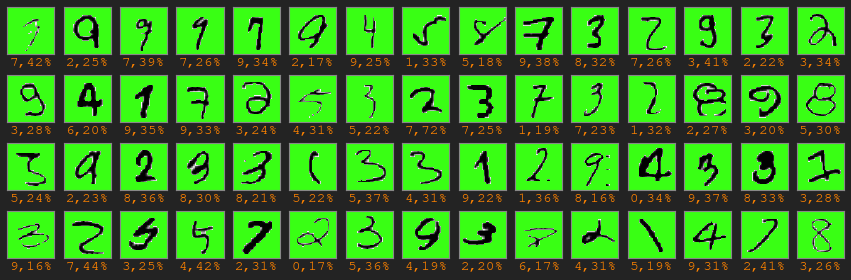

In [43]:
Show_MNIST_digits(mnist_X_val_ext_missclassified, y = mnist_y_val_ext_missclassified, 
                y2 = mnist_y_val_ext_misclsfd_proba, rows = 4, cols = 15, show_labels = True,
                label_delimiter = '%')

In [44]:
# 4s missclassified as 9
mnist_X_val_ext_missclassified_4_as_9 = mnist_X_val[np.logical_and(
                                        mnist_y_val == 4, mnist_y_val_ext_pred == 9)]
mnist_y_val_ext_missclassified_4_as_9 = mnist_y_val_ext_pred[np.logical_and(
                                        mnist_y_val == 4, mnist_y_val_ext_pred == 9)]
mnist_y_val_ext_missclassf_4as9_proba = mnist_y_val_ext_max_proba[np.logical_and(
                                        mnist_y_val == 4, mnist_y_val_ext_pred == 9)]

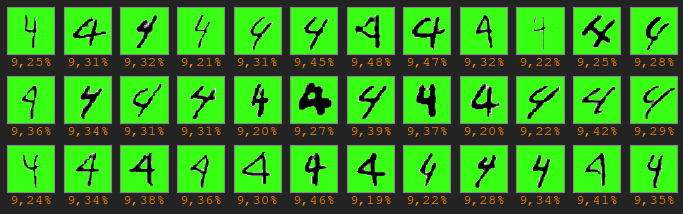

In [47]:
Show_MNIST_digits(mnist_X_val_ext_missclassified_4_as_9, y = mnist_y_val_ext_missclassified_4_as_9, 
                  y2 = mnist_y_val_ext_missclassf_4as9_proba, rows = 3, cols = 12, show_labels = True, 
                  label_delimiter = '%')

In [48]:
# 8s missclassified as 3
mnist_X_val_ext_missclassified_8_as_3 = mnist_X_val[np.logical_and(
                                        mnist_y_val == 8, mnist_y_val_ext_pred == 3)]
mnist_y_val_ext_missclassified_8_as_3 = mnist_y_val_ext_pred[np.logical_and(
                                        mnist_y_val == 8, mnist_y_val_ext_pred == 3)]
mnist_y_val_ext_missclassf_8as3_proba = mnist_y_val_ext_max_proba[np.logical_and(
                                        mnist_y_val == 8, mnist_y_val_ext_pred == 3)]

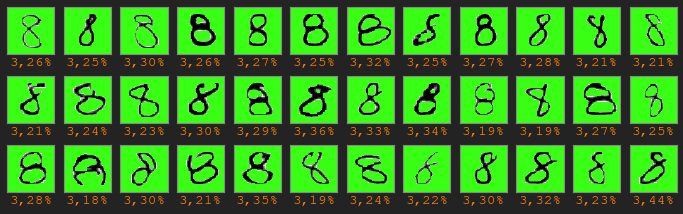

In [50]:
Show_MNIST_digits(mnist_X_val_ext_missclassified_8_as_3, y = mnist_y_val_ext_missclassified_8_as_3, 
                  y2 = mnist_y_val_ext_missclassf_8as3_proba, rows = 3, cols = 12, show_labels = True,
                  label_delimiter = '%')

# Some utilities to automate searching and evaluation

In [119]:
from sklearn.model_selection import GridSearchCV

def evaluate(clf, proba = True, X_train = mnist_X_train_prepped, X_test = mnist_X_test_prepped):
    # Predict on training set
    mnist_y_train_pred = clf.predict(X_train)
    if proba:
        mnist_y_train_proba = clf.predict_proba(X_train)
        mnist_y_train_max_proba = proba_predicted(mnist_y_train_pred, 
                                                  mnist_y_train_proba)

    # Predict on test set
    mnist_y_test_pred = clf.predict(X_test)
    if proba:
        mnist_y_test_proba = clf.predict_proba(X_test)
        mnist_y_test_max_proba = proba_predicted(mnist_y_test_pred, 
                                                mnist_y_test_proba)

    # Show some random test set predictions with probability if available
    Show_MNIST_digits(mnist_X_test, y = mnist_y_test_pred, 
                    y2 = mnist_y_test_max_proba if proba else np.zeros(1), rows = 2, cols = 15, 
                    show_labels = True, label_delimiter = '%' if proba else '')

    # Training Evaluation
    show_metrics(mnist_y_train, mnist_y_train_pred, str(clf.__class__.__name__) + ' TRAINING set confusion matrices')

    # Test Evaluation
    show_metrics(mnist_y_test, mnist_y_test_pred, str(clf.__class__.__name__) + ' TEST set confusion matrices')
    
    return clf
    
def find_best_estimator(clf, parameters, randomized = True, n_iter = 50, cv = 2, X_train = mnist_X_train_prepped):
    if randomized:
        # Set up randomized search
        scv = RandomizedSearchCV(clf, param_distributions = parameters, 
                                 n_iter = n_iter, cv = cv, scoring = 'accuracy', 
                                 verbose = 3, random_state = 42)
    else:
        # Set up grid search
        scv = GridSearchCV(clf, parameters, 
                           cv = cv, scoring = 'accuracy', 
                           verbose = 3)
        
    # Find the best estimator
    scv.fit(X_train, mnist_y_train)
    print('Best ', clf.__class__.__name__, ' -> ', scv.best_estimator_)

    return scv.best_estimator_

# CLF 3 - SoftMax Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression

In [114]:
lgstc_clf_best = find_best_estimator(LogisticRegression(multi_class = 'multinomial', random_state = 1, n_jobs = -1),
                                     {'C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}, False)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2] END .......................................C=0.0001; total time=   4.0s
[CV 2/2] END .......................................C=0.0001; total time=   3.8s
[CV 1/2] END ........................................C=0.001; total time=   7.9s
[CV 2/2] END ........................................C=0.001; total time=   7.7s
[CV 1/2] END .........................................C=0.01; total time=   7.6s
[CV 2/2] END .........................................C=0.01; total time=   7.5s
[CV 1/2] END ..........................................C=0.1; total time=   7.6s
[CV 2/2] END ..........................................C=0.1; total time=   7.8s
[CV 1/2] END ..........................................C=1.0; total time=   7.6s
[CV 2/2] END ..........................................C=1.0; total time=   7.4s
[CV 1/2] END .........................................C=10.0; total time=   7.3s
[CV 2/2] END ....................................

In [79]:
lgstc_clf_best = LogisticRegression(C=0.01, multi_class='multinomial', n_jobs=-1, random_state=1)
lgstc_clf_best.fit(mnist_X_train_prepped, mnist_y_train)

LogisticRegression(C=0.01, multi_class='multinomial', n_jobs=-1, random_state=1)

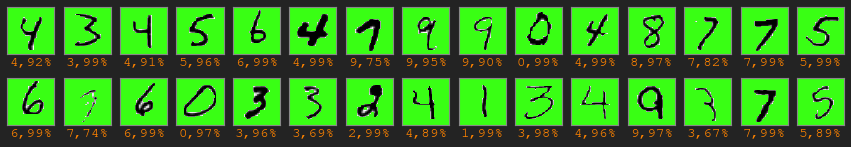

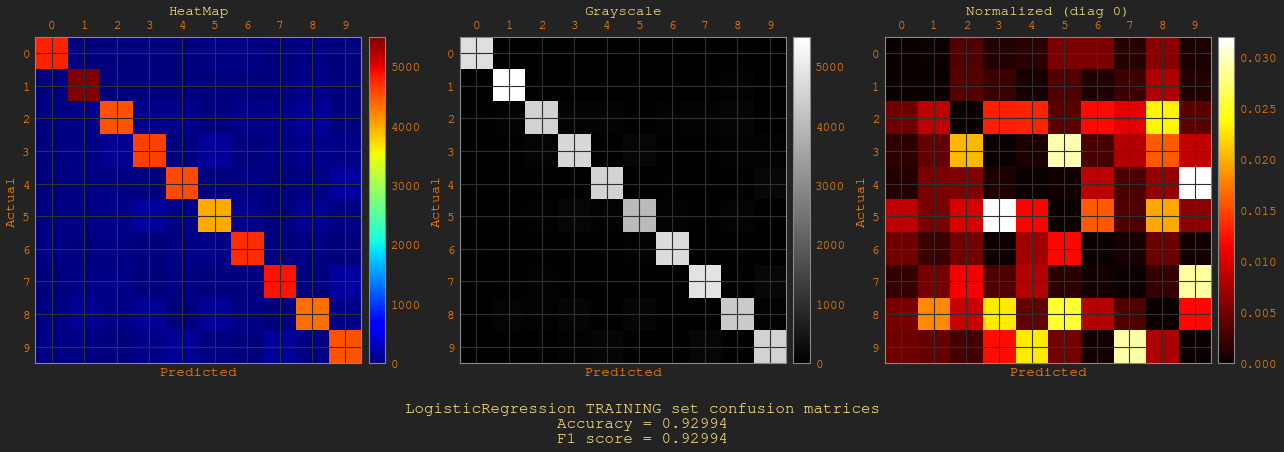

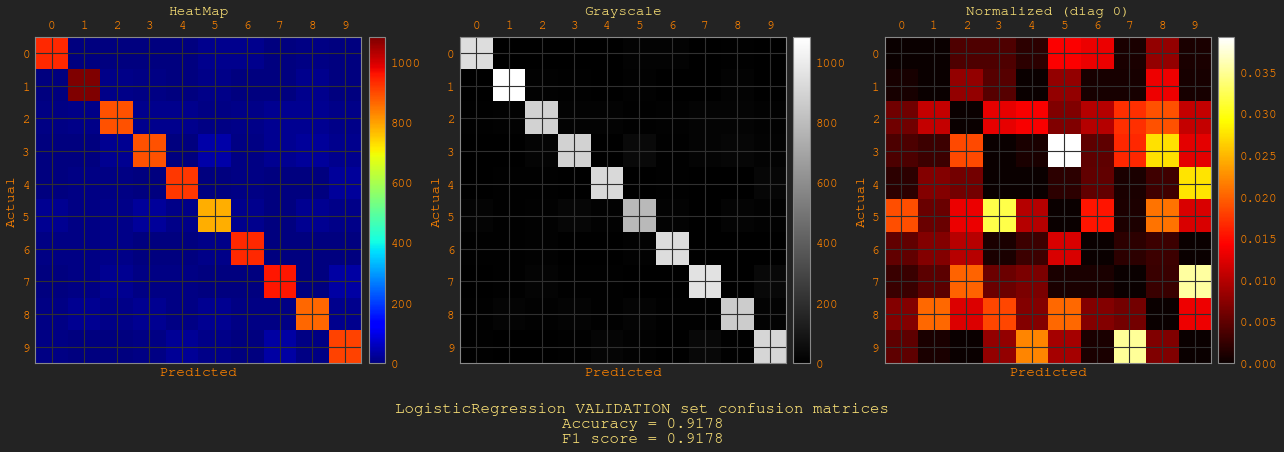

LogisticRegression(C=0.01, multi_class='multinomial', n_jobs=-1, random_state=1)

In [80]:
evaluate(lgstc_clf_best)

# CLF 4 - Linear SVC

In [32]:
from sklearn.svm import LinearSVC

In [29]:
linsv_clf_best = find_best_estimator(LinearSVC(loss = 'hinge', random_state = 2),
                                     {'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'max_iter' : [1000, 10000]}, False)

Fitting 2 folds for each of 14 candidates, totalling 28 fits
[CV 1/2] END .........................C=0.001, max_iter=1000; total time=   3.8s
[CV 2/2] END .........................C=0.001, max_iter=1000; total time=   3.2s
[CV 1/2] END ........................C=0.001, max_iter=10000; total time=   3.8s
[CV 2/2] END ........................C=0.001, max_iter=10000; total time=   3.2s


/home/skullbearer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 1/2] END ..........................C=0.01, max_iter=1000; total time=   4.5s


/home/skullbearer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 2/2] END ..........................C=0.01, max_iter=1000; total time=   4.5s
[CV 1/2] END .........................C=0.01, max_iter=10000; total time=   8.3s
[CV 2/2] END .........................C=0.01, max_iter=10000; total time=   7.8s


/home/skullbearer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 1/2] END ...........................C=0.1, max_iter=1000; total time=  10.2s


/home/skullbearer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 2/2] END ...........................C=0.1, max_iter=1000; total time=  10.8s


/home/skullbearer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 1/2] END ..........................C=0.1, max_iter=10000; total time=  31.9s


/home/skullbearer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 2/2] END ..........................C=0.1, max_iter=10000; total time=  31.3s


/home/skullbearer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 1/2] END ...........................C=1.0, max_iter=1000; total time=  36.8s


/home/skullbearer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 2/2] END ...........................C=1.0, max_iter=1000; total time=  36.2s


/home/skullbearer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 1/2] END ..........................C=1.0, max_iter=10000; total time= 1.1min


/home/skullbearer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 2/2] END ..........................C=1.0, max_iter=10000; total time= 1.1min


/home/skullbearer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 1/2] END ..........................C=10.0, max_iter=1000; total time= 1.2min


/home/skullbearer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 2/2] END ..........................C=10.0, max_iter=1000; total time= 1.2min


/home/skullbearer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 1/2] END .........................C=10.0, max_iter=10000; total time= 4.6min


/home/skullbearer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 2/2] END .........................C=10.0, max_iter=10000; total time= 5.1min


/home/skullbearer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 1/2] END .........................C=100.0, max_iter=1000; total time= 1.4min


/home/skullbearer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 2/2] END .........................C=100.0, max_iter=1000; total time= 1.4min


/home/skullbearer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 1/2] END ........................C=100.0, max_iter=10000; total time= 9.5min


/home/skullbearer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 2/2] END ........................C=100.0, max_iter=10000; total time= 9.2min


/home/skullbearer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 1/2] END ........................C=1000.0, max_iter=1000; total time= 1.4min


/home/skullbearer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 2/2] END ........................C=1000.0, max_iter=1000; total time= 1.4min


/home/skullbearer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 1/2] END .......................C=1000.0, max_iter=10000; total time= 9.6min


/home/skullbearer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV 2/2] END .......................C=1000.0, max_iter=10000; total time= 9.5min
Best  LinearSVC  ->  LinearSVC(C=0.1, loss='hinge', random_state=2)


/home/skullbearer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [33]:
from sklearn.calibration import CalibratedClassifierCV

In [46]:
linsv_clf_best = LinearSVC(C=0.1, loss='hinge', random_state=2)
# separate into training and caliberation
X_fit, X_calib, y_fit, y_calib = train_test_split(
    mnist_X_train_prepped, mnist_y_train, stratify = mnist_y_train, train_size = 5.2 / 6.0, random_state = 42)
# fit on the best extimator
linsv_clf_best.fit(X_fit, y_fit)
# calibrate for probability
linsv_clf_best_wproba = CalibratedClassifierCV(base_estimator = linsv_clf_best, cv = 'prefit')
linsv_clf_best_wproba.fit(X_calib, y_calib)

/home/skullbearer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CalibratedClassifierCV(base_estimator=LinearSVC(C=0.1, loss='hinge',
                                                random_state=2),
                       cv='prefit')

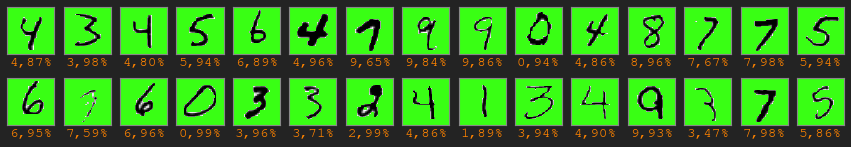

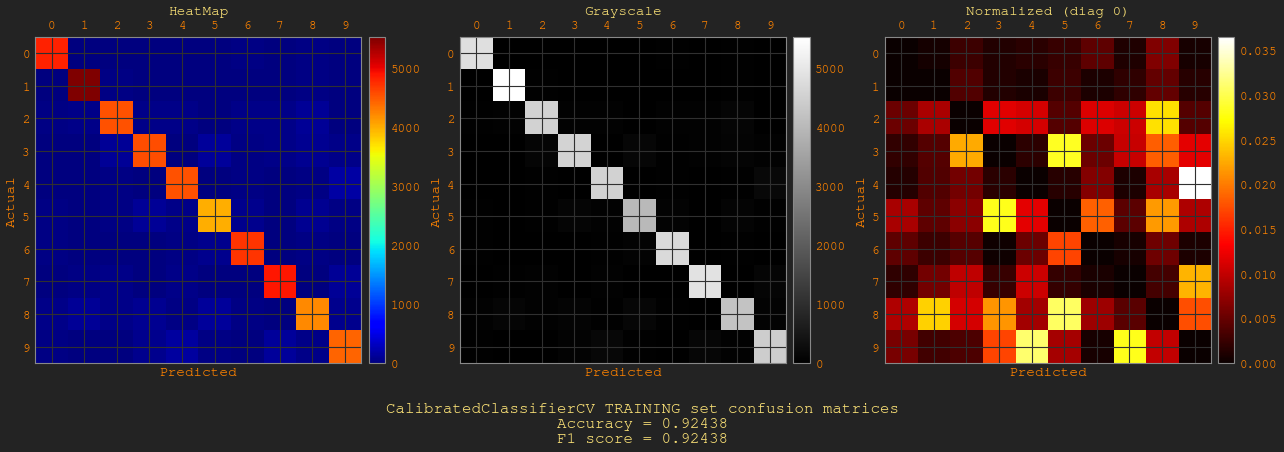

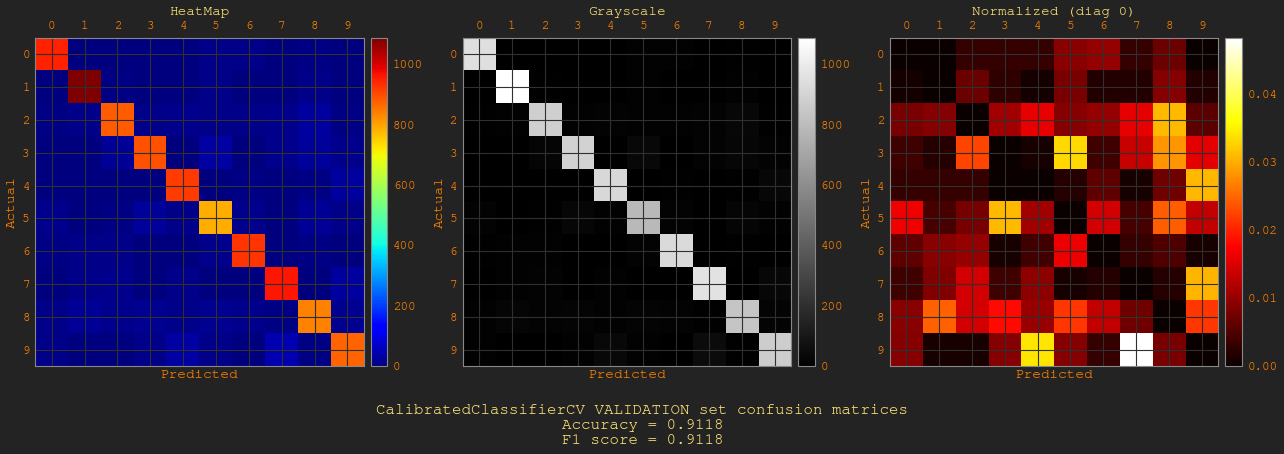

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.1, loss='hinge',
                                                random_state=2),
                       cv='prefit')

In [47]:
evaluate(linsv_clf_best_wproba)

# CLF 5 - Gaussian SVM 

In [34]:
from sklearn.svm import SVC

In [38]:
gsvm_clf_best = find_best_estimator(SVC(kernel = 'rbf', random_state = 2),
                     {'C': [0.1, 1.0, 10.0],
                     'gamma': ['auto', 'scale', 1, 5]}, False)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV 1/2] END ..............................C=0.1, gamma=auto; total time= 3.2min
[CV 2/2] END ..............................C=0.1, gamma=auto; total time= 3.1min
[CV 1/2] END .............................C=0.1, gamma=scale; total time= 3.1min
[CV 2/2] END .............................C=0.1, gamma=scale; total time= 3.1min
[CV 1/2] END .................................C=0.1, gamma=1; total time= 9.9min
[CV 2/2] END .................................C=0.1, gamma=1; total time= 9.9min
[CV 1/2] END .................................C=0.1, gamma=5; total time= 9.4min
[CV 2/2] END .................................C=0.1, gamma=5; total time= 9.4min
[CV 1/2] END ..............................C=1.0, gamma=auto; total time= 1.8min
[CV 2/2] END ..............................C=1.0, gamma=auto; total time= 1.8min
[CV 1/2] END .............................C=1.0, gamma=scale; total time= 1.8min
[CV 2/2] END .............................C=1.0,

In [25]:
gsvm_clf_best = SVC(kernel = 'rbf', C=10.0, gamma='auto', probability = True, random_state=2)
gsvm_clf_best.fit(mnist_X_train_prepped, mnist_y_train)

SVC(C=10.0, gamma='auto', probability=True, random_state=2)

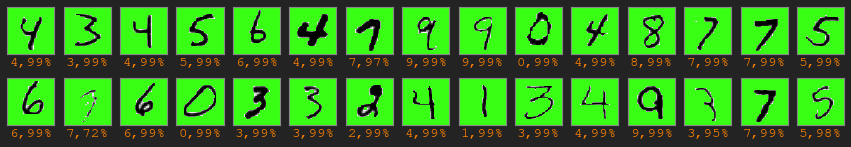

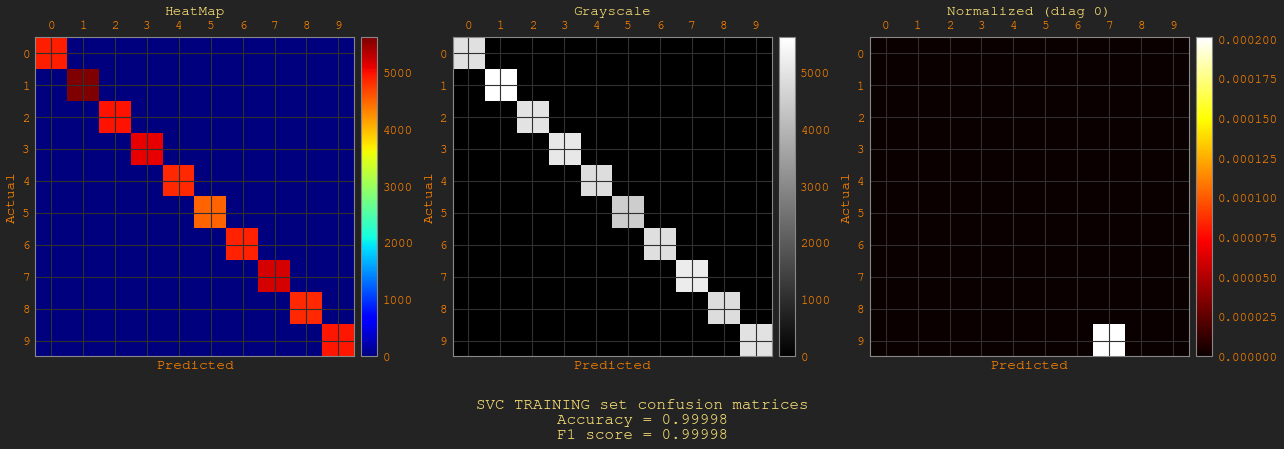

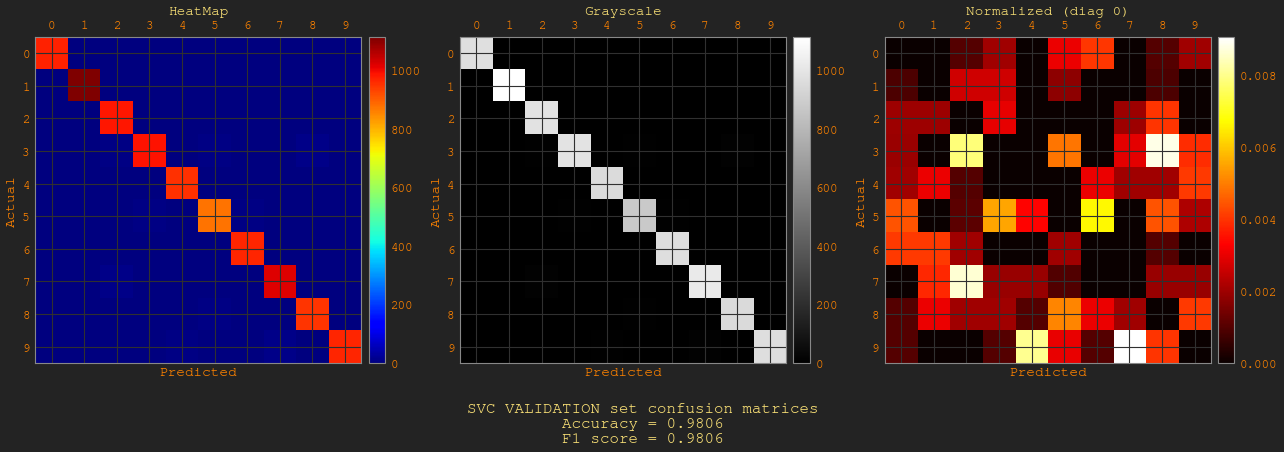

SVC(C=10.0, gamma='auto', probability=True, random_state=2)

In [26]:
evaluate(gsvm_clf_best)

# CLF 6 - Gradient Boost

In [64]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [ ]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_fit, y_fit, eval_set = [(X_calib, y_calib)], early_stopping_rounds = 10)

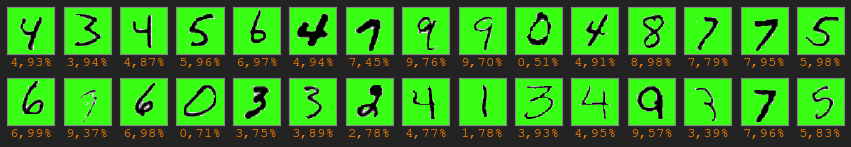

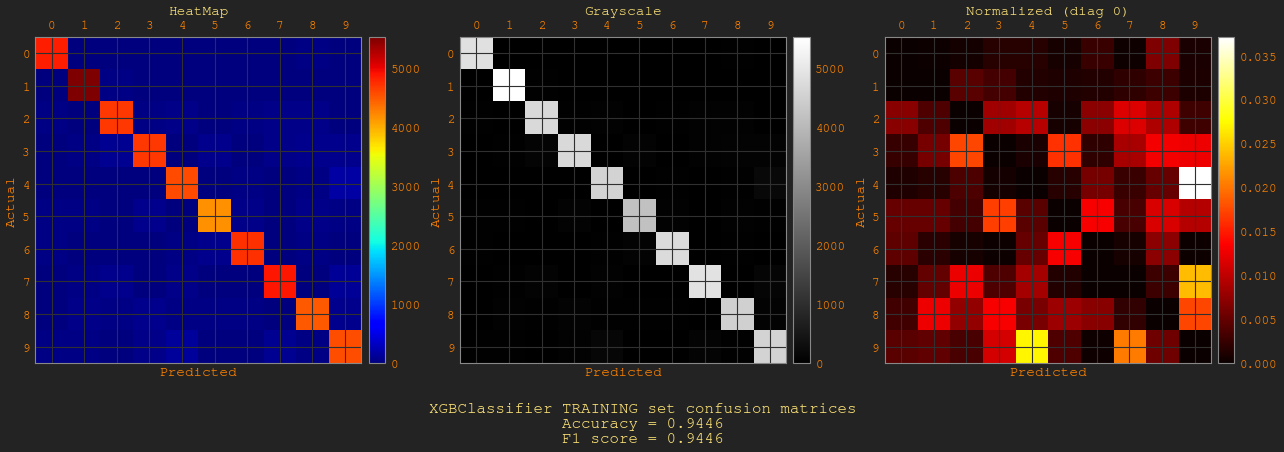

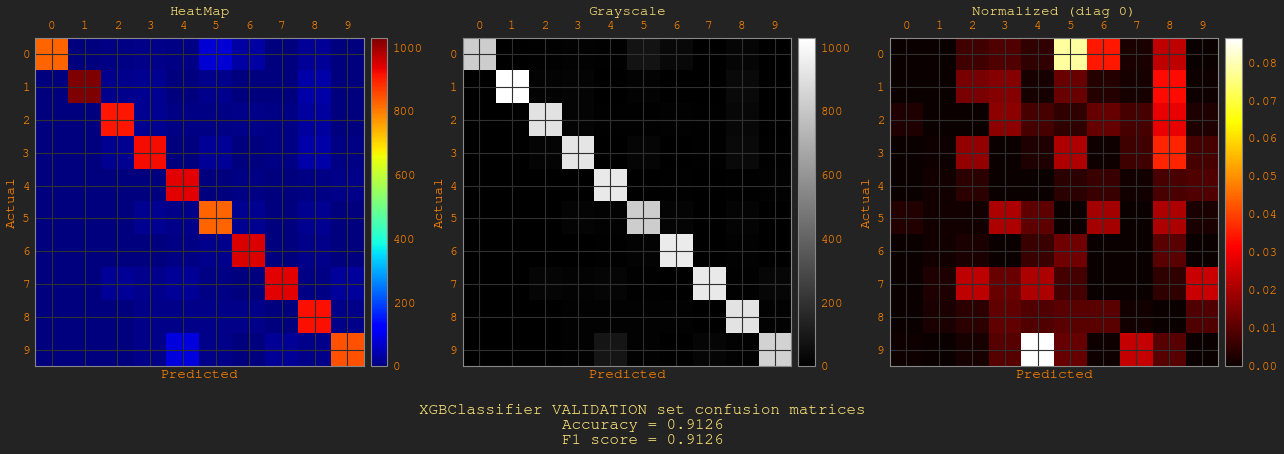

XGBClassifier(objective='multi:softprob')

In [49]:
evaluate(xgb_clf)

In [52]:
xgtrain = xgb.DMatrix(mnist_X_train_prepped, label = mnist_y_train)

In [30]:
xgb_clf = XGBClassifier(n_estimators = 1000)

In [71]:
params = xgb_clf.get_xgb_params()
params['num_class'] = 10 
cvresult = xgb.cv(params, xgtrain, num_boost_round = 1000, nfold = 3, seed = 42,
                  metrics = {'merror'}, early_stopping_rounds = 10, verbose_eval = True)

[0]	train-merror:0.289+0.00427724	test-merror:0.29478+0.00310467
[1]	train-merror:0.23149+0.00229647	test-merror:0.23878+0.00671062
[2]	train-merror:0.21414+0.00168143	test-merror:0.22084+0.00644104
[3]	train-merror:0.19954+0.00218771	test-merror:0.2044+0.0028232
[4]	train-merror:0.19116+0.00248422	test-merror:0.19764+0.00103832
[5]	train-merror:0.18469+0.00261288	test-merror:0.19062+0.00120759
[6]	train-merror:0.17835+0.00066037	test-merror:0.1841+0.000887243
[7]	train-merror:0.17218+0.00057562	test-merror:0.17884+0.000453931
[8]	train-merror:0.1663+0.000540961	test-merror:0.1726+0.000302912
[9]	train-merror:0.16204+0.000293153	test-merror:0.16864+0.00101851
[10]	train-merror:0.15815+0.000989733	test-merror:0.16498+0.00118328
[11]	train-merror:0.15329+0.00143355	test-merror:0.16012+0.0021928
[12]	train-merror:0.14935+0.00150309	test-merror:0.15628+0.00124244
[13]	train-merror:0.14658+0.00108836	test-merror:0.154+0.00193155
[14]	train-merror:0.14341+0.00091821	test-merror:0.15054+0.001

[117]	train-merror:0.0431797+0.000281366	test-merror:0.06122+0.00164624
[118]	train-merror:0.0425297+0.000285646	test-merror:0.06076+0.00158991
[119]	train-merror:0.0421997+0.00019762	test-merror:0.06068+0.00138613
[120]	train-merror:0.0417297+0.000127044	test-merror:0.06036+0.00152747
[121]	train-merror:0.0413497+0.000139165	test-merror:0.06004+0.00137132
[122]	train-merror:0.0410497+0.000166874	test-merror:0.05978+0.00147008
[123]	train-merror:0.0407297+0.000284172	test-merror:0.05944+0.00145785
[124]	train-merror:0.0404197+0.000296626	test-merror:0.05936+0.0014296
[125]	train-merror:0.0401797+0.000231834	test-merror:0.05904+0.00144503
[126]	train-merror:0.0399997+0.000338241	test-merror:0.05854+0.00146118
[127]	train-merror:0.0395297+0.000220938	test-merror:0.05832+0.0014452
[128]	train-merror:0.0392697+0.000318654	test-merror:0.05802+0.00127209
[129]	train-merror:0.0389497+0.000332787	test-merror:0.05798+0.00125084
[130]	train-merror:0.0385697+0.00034692	test-merror:0.0578+0.001304

[233]	train-merror:0.01716+0.000233666	test-merror:0.04446+0.001382
[234]	train-merror:0.01705+0.000237908	test-merror:0.04436+0.00151791
[235]	train-merror:0.01685+0.000264197	test-merror:0.04416+0.00129888
[236]	train-merror:0.01681+0.000334365	test-merror:0.04408+0.00125327
[237]	train-merror:0.01665+0.000340294	test-merror:0.04398+0.00132535
[238]	train-merror:0.01663+0.000384448	test-merror:0.04396+0.00147084
[239]	train-merror:0.01654+0.000350143	test-merror:0.04392+0.00147222
[240]	train-merror:0.01635+0.000278209	test-merror:0.044+0.00146999
[241]	train-merror:0.01628+0.000211187	test-merror:0.04386+0.00140213
[242]	train-merror:0.01619+0.000187083	test-merror:0.04396+0.00143883
[243]	train-merror:0.01607+0.000246577	test-merror:0.0439+0.00144868
[244]	train-merror:0.01596+0.000305941	test-merror:0.04382+0.00140501
[245]	train-merror:0.01577+0.00015748	test-merror:0.0438+0.00144358
[246]	train-merror:0.01566+0.000209284	test-merror:0.04382+0.00136875
[247]	train-merror:0.01554+

[351]	train-merror:0.00637+0.00012083	test-merror:0.03768+0.000641188
[352]	train-merror:0.00635+0.000155563	test-merror:0.0378+0.00047295
[353]	train-merror:0.00631+0.000163095	test-merror:0.03774+0.000512057
[354]	train-merror:0.00625+0.000110454	test-merror:0.03776+0.000568403
[355]	train-merror:0.00619+0.000149666	test-merror:0.03758+0.000529266
[356]	train-merror:0.00616+0.000143527	test-merror:0.0376+0.00050128
[357]	train-merror:0.00604+0.000227596	test-merror:0.03748+0.000593567
[358]	train-merror:0.00595+0.000163095	test-merror:0.03754+0.000585322
[359]	train-merror:0.00592+0.000163095	test-merror:0.03746+0.000491652
[360]	train-merror:0.00579+0.000176635	test-merror:0.03738+0.000483489
[361]	train-merror:0.00574+0.000226274	test-merror:0.0374+0.000483903
[362]	train-merror:0.00569+0.000180555	test-merror:0.03728+0.000439866
[363]	train-merror:0.00561+0.000171464	test-merror:0.0372397+0.000347718
[364]	train-merror:0.00556+0.000196469	test-merror:0.03732+0.000340121
[365]	trai

[465]	train-merror:0.0015+0.000106771	test-merror:0.0336997+0.000140952
[466]	train-merror:0.00149+9.27362e-05	test-merror:0.0337397+0.000149847
[467]	train-merror:0.0015+0.000127279	test-merror:0.0338397+0.000130234
[468]	train-merror:0.00144+0.000136382	test-merror:0.0337197+0.000176864
[469]	train-merror:0.00142+0.000125698	test-merror:0.0336197+0.000149847
[470]	train-merror:0.0014+0.000123288	test-merror:0.0335997+0.000176864
[471]	train-merror:0.00138+0.000136382	test-merror:0.0335797+0.000204616
[472]	train-merror:0.00137+0.000123288	test-merror:0.0336597+9.87972e-05
[473]	train-merror:0.00137+0.000123288	test-merror:0.0335997+0.000129926
[474]	train-merror:0.00135+0.00011225	test-merror:0.0333797+0.000232151
[475]	train-merror:0.00135+0.000136382	test-merror:0.0334197+0.000259848
[476]	train-merror:0.00135+0.00011225	test-merror:0.0333597+0.000259848
[477]	train-merror:0.00129+0.000122474	test-merror:0.0333197+0.000315554
[478]	train-merror:0.00125+0.000110454	test-merror:0.033

[578]	train-merror:0.00016+6.16441e-05	test-merror:0.0309997+0.000381192
[579]	train-merror:0.00015+7.34847e-05	test-merror:0.0310197+0.000436074
[580]	train-merror:0.00015+7.34847e-05	test-merror:0.0310197+0.000298531
[581]	train-merror:0.00015+7.34847e-05	test-merror:0.0310797+0.000401698
[582]	train-merror:0.00015+7.34847e-05	test-merror:0.0309997+0.000417262
[583]	train-merror:0.00014+6.16441e-05	test-merror:0.0309997+0.000417262
[584]	train-merror:0.00014+6.16441e-05	test-merror:0.0309197+0.000326886
[585]	train-merror:0.00014+6.16441e-05	test-merror:0.0308397+0.00035395
[586]	train-merror:0.00014+6.16441e-05	test-merror:0.0309197+0.000326886
[587]	train-merror:0.00014+6.16441e-05	test-merror:0.0308197+0.000381192
[588]	train-merror:0.00014+6.16441e-05	test-merror:0.0308197+0.000428705
[589]	train-merror:0.00014+6.16441e-05	test-merror:0.0308197+0.000476516
[590]	train-merror:0.00014+6.16441e-05	test-merror:0.0308597+0.000408576
[591]	train-merror:0.00013+7.48331e-05	test-merror:0

In [72]:
cvresult

,train-merror-mean,train-merror-std,test-merror-mean,test-merror-std
0,0.28900,0.004277,0.29478,0.003105
1,0.23149,0.002296,0.23878,0.006711
2,0.21414,0.001681,0.22084,0.006441
3,0.19954,0.002188,0.20440,0.002823
4,0.19116,0.002484,0.19764,0.001038
...,...,...,...,...
583,0.00014,0.000062,0.03100,0.000417
584,0.00014,0.000062,0.03092,0.000327
585,0.00014,0.000062,0.03084,0.000354
586,0.00014,0.000062,0.03092,0.000327


In [31]:
xgb_clf.set_params(n_estimators = 588, gpu_id = 0, nthread = 8, seed = 0)

XGBClassifier(gpu_id=0, n_estimators=588, nthread=8, seed=0)

In [32]:
gsvm_clf_best = find_best_estimator(xgb_clf,
                                   {'max_depth':range(3,10,2),
                                    'min_child_weight':range(1,6,2)}, False)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV 1/2] END ................max_depth=3, min_child_weight=1; total time= 2.7min
[CV 2/2] END ................max_depth=3, min_child_weight=1; total time= 2.6min
[CV 1/2] END ................max_depth=3, min_child_weight=3; total time= 2.6min
[CV 2/2] END ................max_depth=3, min_child_weight=3; total time= 2.6min
[CV 1/2] END ................max_depth=3, min_child_weight=5; total time= 2.6min
[CV 2/2] END ................max_depth=3, min_child_weight=5; total time= 2.6min
[CV 1/2] END ................max_depth=5, min_child_weight=1; total time= 4.3min
[CV 2/2] END ................max_depth=5, min_child_weight=1; total time= 4.2min
[CV 1/2] END ................max_depth=5, min_child_weight=3; total time= 4.1min
[CV 2/2] END ................max_depth=5, min_child_weight=3; total time= 4.1min
[CV 1/2] END ................max_depth=5, min_child_weight=5; total time= 4.0min
[CV 2/2] END ................max_depth=5, min_ch

In [40]:
gsvm_clf_best.fit(mnist_X_train_prepped, mnist_y_train)

XGBClassifier(gpu_id=0, max_depth=5, n_estimators=588, nthread=8,
              objective='multi:softprob', seed=0)

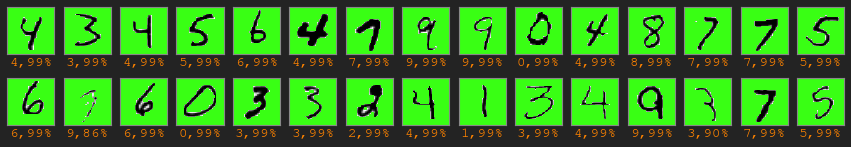

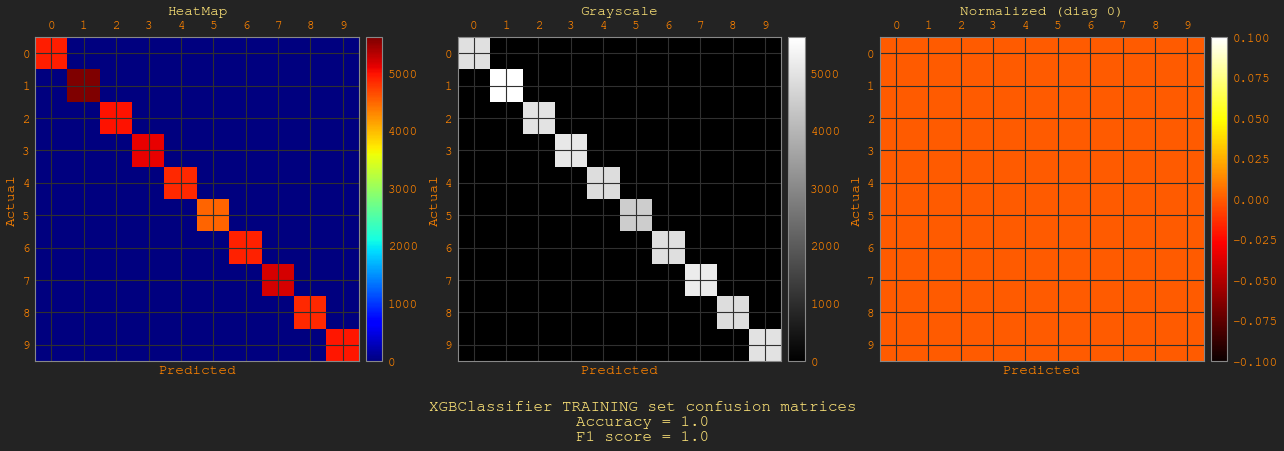

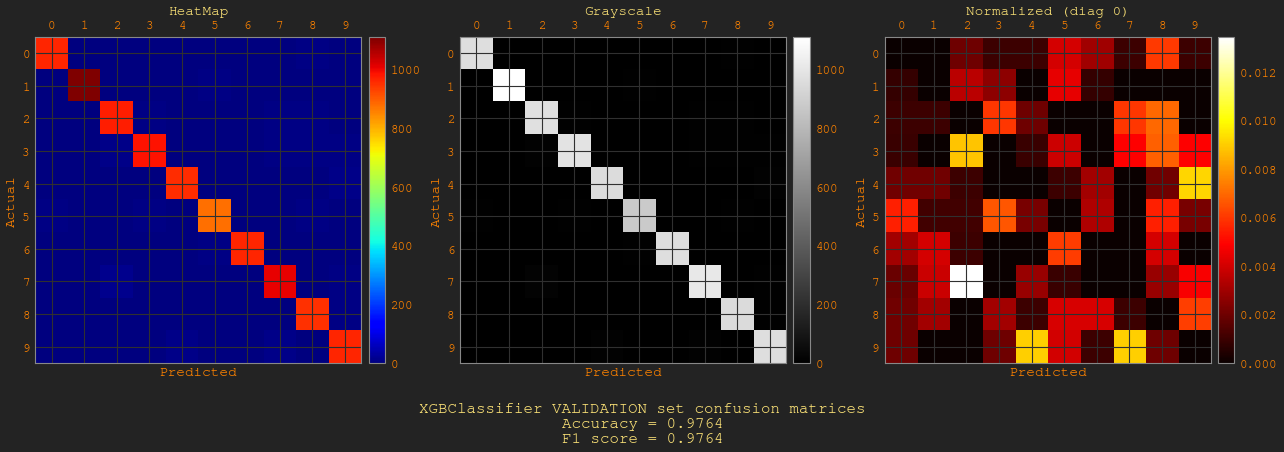

XGBClassifier(gpu_id=0, max_depth=5, n_estimators=588, nthread=8,
              objective='multi:softprob', seed=0)

In [39]:
evaluate(gsvm_clf_best)

# Voting on Classifiers with < 95% acc.

In [36]:
from sklearn.ensemble import VotingClassifier

In [31]:
# The best Random forest
hv_rndf_clf = RandomForestClassifier(max_depth = 15, max_leaf_nodes = 399, min_samples_leaf = 271,
                       n_estimators = 456, n_jobs = -1, random_state = 42)
# The best Extra Trees
hv_ext_clf = ExtraTreesClassifier(max_depth = 14, max_leaf_nodes = 602, min_samples_leaf = 114,
                                  n_estimators = 253, n_jobs = -1, random_state = 0)
# The best Softmax
hv_sftmx_clf = LogisticRegression(C = 0.01, multi_class = 'multinomial', n_jobs = -1, random_state = 1)
# The best Linear SVC with calibearation for probability
hv_linsv_clf = CalibratedClassifierCV(base_estimator = LinearSVC(C = 0.1, loss = 'hinge', random_state = 2), 
                                             cv = 3, n_jobs = -1)

In [65]:
hv_clf = VotingClassifier(estimators = [('rndf', hv_rndf_clf), ('ext', hv_ext_clf), 
                                        ('sftmx', hv_sftmx_clf), ('linsv', hv_linsv_clf)], 
                                        voting = 'hard', verbose = True)
hv_clf.fit(mnist_X_train_prepped, mnist_y_train)

[Voting] ..................... (1 of 4) Processing rndf, total=  14.3s
[Voting] ...................... (2 of 4) Processing ext, total=  11.0s
[Voting] .................... (3 of 4) Processing sftmx, total=  14.6s
[Voting] .................... (4 of 4) Processing linsv, total=  27.8s


VotingClassifier(estimators=[('rndf',
                              RandomForestClassifier(max_depth=15,
                                                     max_leaf_nodes=399,
                                                     min_samples_leaf=271,
                                                     n_estimators=456,
                                                     n_jobs=-1,
                                                     random_state=42)),
                             ('ext',
                              ExtraTreesClassifier(max_depth=14,
                                                   max_leaf_nodes=602,
                                                   min_samples_leaf=114,
                                                   n_estimators=253, n_jobs=-1,
                                                   random_state=0)),
                             ('sftmx',
                              LogisticRegression(C=0.01,
                                                 

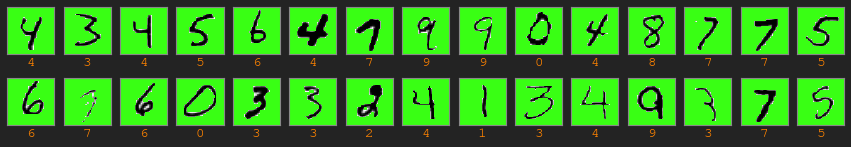

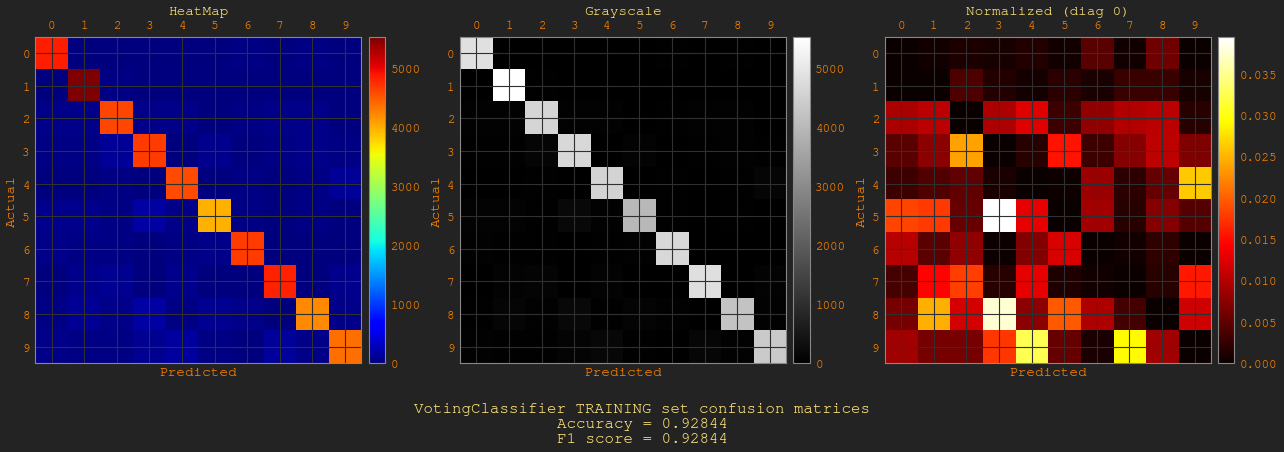

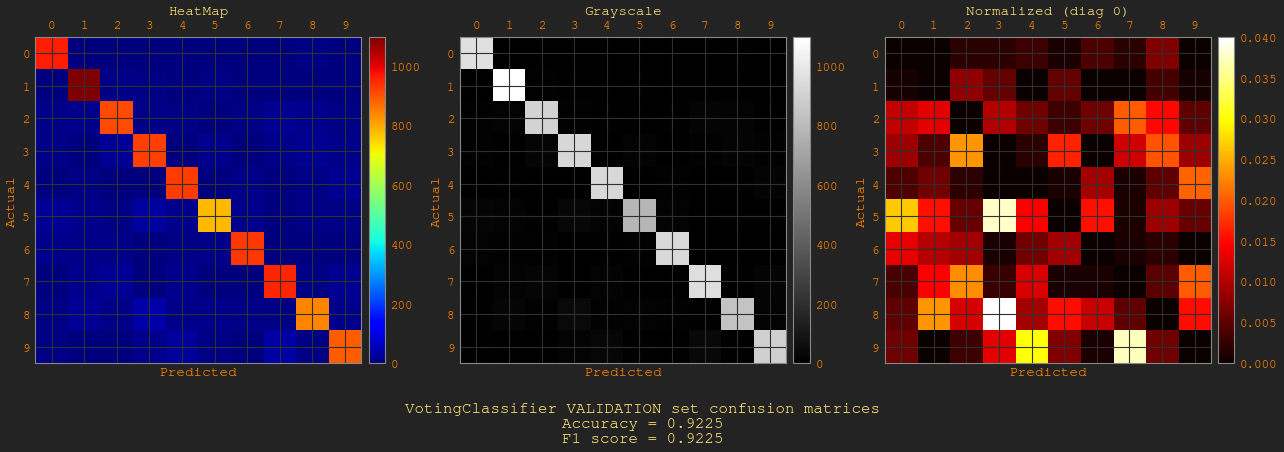

VotingClassifier(estimators=[('rndf',
                              RandomForestClassifier(max_depth=15,
                                                     max_leaf_nodes=399,
                                                     min_samples_leaf=271,
                                                     n_estimators=456,
                                                     n_jobs=-1,
                                                     random_state=42)),
                             ('ext',
                              ExtraTreesClassifier(max_depth=14,
                                                   max_leaf_nodes=602,
                                                   min_samples_leaf=114,
                                                   n_estimators=253, n_jobs=-1,
                                                   random_state=0)),
                             ('sftmx',
                              LogisticRegression(C=0.01,
                                                 

In [66]:
evaluate(hv_clf, False)

In [67]:
sv_clf = VotingClassifier(estimators = [('rndf', hv_rndf_clf), ('ext', hv_ext_clf), 
                                        ('sftmx', hv_sftmx_clf), ('linsv', hv_linsv_clf)], 
                                        voting = 'soft', verbose = True)
sv_clf.fit(mnist_X_train_prepped, mnist_y_train)

[Voting] ..................... (1 of 4) Processing rndf, total=  13.2s
[Voting] ...................... (2 of 4) Processing ext, total=  10.6s
[Voting] .................... (3 of 4) Processing sftmx, total=  14.4s
[Voting] .................... (4 of 4) Processing linsv, total=  26.5s


VotingClassifier(estimators=[('rndf',
                              RandomForestClassifier(max_depth=15,
                                                     max_leaf_nodes=399,
                                                     min_samples_leaf=271,
                                                     n_estimators=456,
                                                     n_jobs=-1,
                                                     random_state=42)),
                             ('ext',
                              ExtraTreesClassifier(max_depth=14,
                                                   max_leaf_nodes=602,
                                                   min_samples_leaf=114,
                                                   n_estimators=253, n_jobs=-1,
                                                   random_state=0)),
                             ('sftmx',
                              LogisticRegression(C=0.01,
                                                 

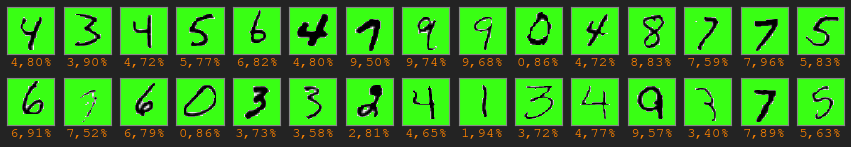

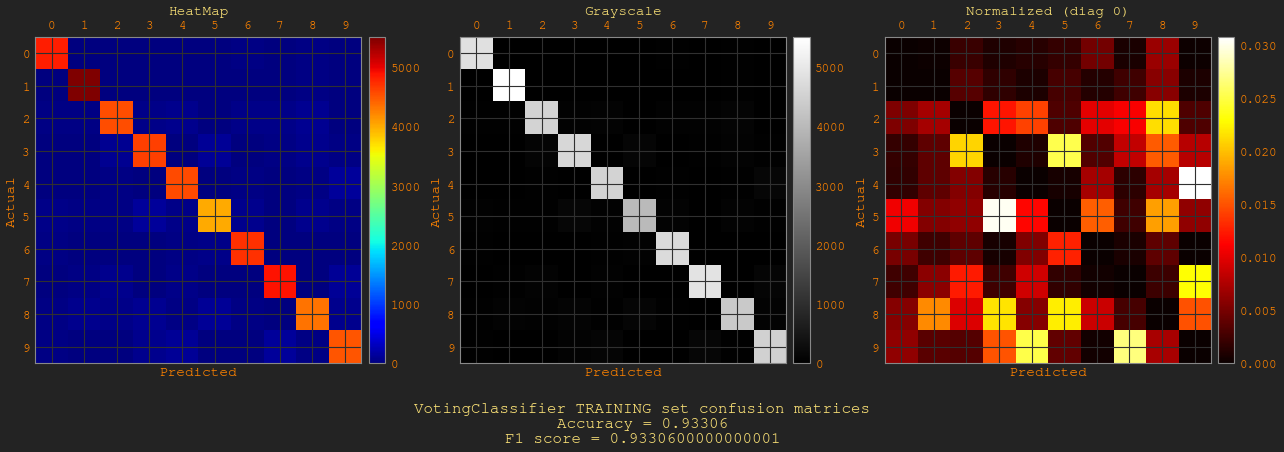

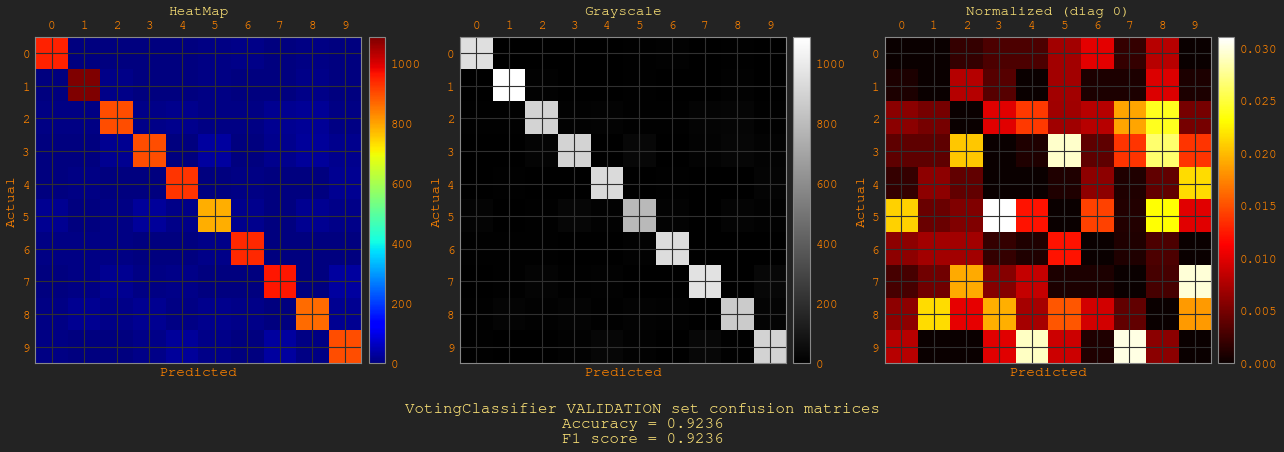

VotingClassifier(estimators=[('rndf',
                              RandomForestClassifier(max_depth=15,
                                                     max_leaf_nodes=399,
                                                     min_samples_leaf=271,
                                                     n_estimators=456,
                                                     n_jobs=-1,
                                                     random_state=42)),
                             ('ext',
                              ExtraTreesClassifier(max_depth=14,
                                                   max_leaf_nodes=602,
                                                   min_samples_leaf=114,
                                                   n_estimators=253, n_jobs=-1,
                                                   random_state=0)),
                             ('sftmx',
                              LogisticRegression(C=0.01,
                                                 

In [68]:
evaluate(sv_clf)

# Stacking Classifier

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from multiprocessing import Process
from multiprocessing import Pool

In [43]:
class StackingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, layered_predictors, blender, blend_split = 0.2, verbose = True, random_state = 0):
        self.layered_predictors = layered_predictors.copy()
        self.layered_predictors.append({'blender' : blender})
        self.blender = blender
        self.num_layers = len(self.layered_predictors)
        self.blend_split = blend_split
        self.verbose = verbose
        self.random_state = random_state
        self.layer_results = []
        
    def process_fitter(self, name, predictor, X, y):
        if self.verbose:
            print('Fitting ' + name + ' -> ' + str(predictor.__class__.__name__) + '\n')
        predictor.fit(X, y)
        return (name, predictor)
    
    def process_predictor(self, predictor):
        if self.verbose:
            print('Predicting ' + str(predictor.__class__.__name__) + ' for new layer'+ '\n')
        return predictor.predict(self.current_features)
    
    def predict_layer_until(self, X, layer_id, store_results = False):
        # Clear the results arry for fresh results
        self.layer_results.clear()
        # set the current features to be processed
        self.current_features = X
        # Get predictions from previous layers
        for i in range(layer_id):
            # Get the layer
            predictor_layer = self.layered_predictors[i]
            if __name__ == '__main__':
                # Create a pool for the predictors in the layer
                prediction_pool = Pool(processes = len(predictor_layer.values()))
                # Add predictors to the pool
                predictions = prediction_pool.map(self.process_predictor, predictor_layer.values())
                # Wait for pool to finish
                prediction_pool.close()
                prediction_pool.join()
                # Create new feature set
                new_X = np.concatenate([pred.reshape(-1, 1) for pred in predictions], axis = 1)
                if store_results:
                    self.layer_results.append(new_X)
                self.current_features = new_X
        
    def process_layer(self, X, y, layer_id):
        # Get predictions from previous layers
        self.predict_layer_until(X, layer_id)
        # Now get the current layer / blender
        current_layer = self.layered_predictors[layer_id]
        # A list of jobs to be populated by current layer predictors
        args = []
        for key in current_layer.keys():
            args.append((key, current_layer[key], self.current_features, y))
        if __name__ == '__main__':
            # Create a pool for the predictors in the layer
            fitting_pool = Pool(processes = len(current_layer.values()))
            # Add predictors to the pool
            fitted_predictors = fitting_pool.starmap(self.process_fitter, args)
            # Wait for pool to finish
            fitting_pool.close()
            fitting_pool.join()
        current_layer.update(fitted_predictors)
    
    def fit(self, X, y):
        # set the random state
        np.random.seed(self.random_state)
        # separate into blender and train set
        X_blend, X_train, y_blend, y_train = train_test_split(X, y, stratify = y, 
                                                              train_size = self.blend_split)
        # further split train set into folds for each layer
        folds = []
        if self.num_layers > 1:
            skf = StratifiedKFold(n_splits = self.num_layers)
            for rest_index, fold_index in skf.split(X_train, y_train):
                folds.append((X_train[fold_index], y_train[fold_index]))
        else:
            folds = [(X_train, y_train)]
        
        # process each layer
        for i in range(self.num_layers):
            if self.verbose:
                print('TRAINING LAYER ' + str(i) + '\n')
            layer_dataset = folds[i]
            self.process_layer(layer_dataset[0], layer_dataset[1], i)   
            
        return self
                
    def predict(self, X):
        verbose = self.verbose
        self.verbose = False
        self.predict_layer_until(X, self.num_layers, True)
        self.verbose = verbose
        return self.current_features
    

In [4]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

TRAINING LAYER 0

Fitting c2 -> KNeighborsClassifier
Fitting c3 -> AdaBoostClassifier


Fitting c1 -> RandomForestClassifier

TRAINING LAYER 1

Predicting RandomForestClassifier for new layer

Predicting KNeighborsClassifier for new layer
Predicting AdaBoostClassifier for new layer


Fitting c4 -> LogisticRegression

Fitting c5 -> SVC

TRAINING LAYER 2

Predicting RandomForestClassifier for new layer

Predicting KNeighborsClassifier for new layer

Predicting AdaBoostClassifier for new layer

Predicting LogisticRegression for new layer

Predicting SVC for new layer

Fitting blender -> GaussianNB

ACCURACY =  0.8825


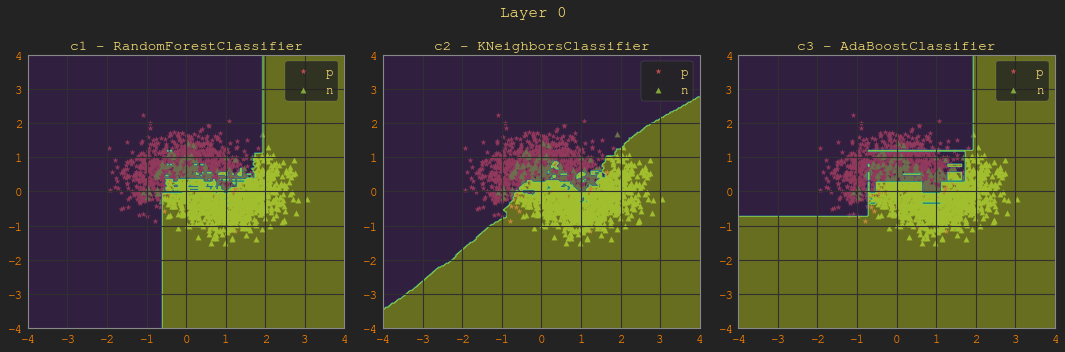

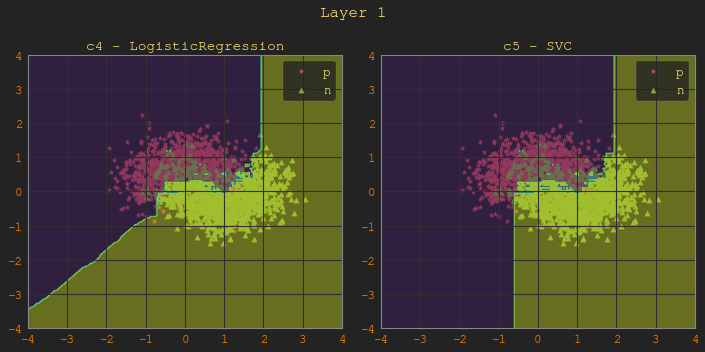

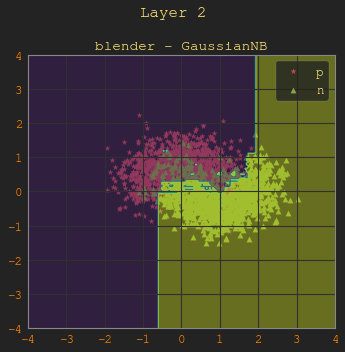

In [46]:
clf1 = RandomForestClassifier()
clf2 = KNeighborsClassifier()
clf3 = AdaBoostClassifier()
clf4 = LogisticRegression()
clf5 = SVC()
blender = GaussianNB()

X,y = make_moons(n_samples = 2000, noise = 0.4)

scaler =  StandardScaler()
X_scaled = scaler.fit_transform(X)

stack_clf = StackingClassifier([{'c1': clf1, 'c2': clf2, 'c3': clf3},
                               {'c4': clf4, 'c5': clf5}], blender)

stack_clf.fit(X_scaled, y)

y_pred = stack_clf.predict(X_scaled)
print('ACCURACY = ', accuracy_score(y, y_pred))

x_grid = np.linspace(-4, 4, 200)
y_grid = np.linspace(-4, 4, 200)

x1, x2 = np.meshgrid(x_grid, y_grid)  
x_flat = np.c_[x1.ravel(), x2.ravel()]
    
y_pred_g = stack_clf.predict(scaler.transform(x_flat)).reshape(x1.shape)

layer = 0
for layer_pred in stack_clf.layer_results:
    num_predictors = layer_pred.shape[1]
    predictors = list(stack_clf.layered_predictors[layer].keys())
    fig, ax = plt.subplots(nrows = 1, ncols = num_predictors, figsize = (5 * num_predictors, 5), squeeze = False)
    for column in range(num_predictors):
        ax[0][column].scatter(X[:, 0][y == 0], X[:, 1][y == 0], color = 'r', marker = '*', label = 'p')
        ax[0][column].scatter(X[:, 0][y == 1], X[:, 1][y == 1], color = 'g', marker = '^', label = 'n')
        y_p = layer_pred[:, column].reshape(x1.shape)
        ax[0][column].contourf(x1, x2, y_p, alpha=0.4)
        p_name = predictors[column]
        ax[0][column].set_title(str(p_name) + ' - ' + 
                                str(stack_clf.layered_predictors[layer][p_name].__class__.__name__))
        ax[0][column].legend()
        plt.suptitle('Layer ' + str(layer))
        plt.tight_layout()
    plt.show()
    layer += 1

# Stacking on MNIST

In [59]:
from sklearn.neural_network import MLPClassifier

In [65]:
# The best Random forest
st_rndf_clf = RandomForestClassifier(max_depth = 15, max_leaf_nodes = 399, min_samples_leaf = 271,
                       n_estimators = 456, random_state = 42)
# The best Extra Trees
st_ext_clf = ExtraTreesClassifier(max_depth = 14, max_leaf_nodes = 602, min_samples_leaf = 114,
                                  n_estimators = 253, random_state = 0)
# The best Softmax
st_sftmx_clf = LogisticRegression(C = 0.01, multi_class = 'multinomial', random_state = 1)
# The best Linear SVC 
st_linsv_clf = LinearSVC(C = 0.1, loss = 'hinge', random_state = 2)
# The best Gaussian SVC
st_gsvm_clf = SVC(kernel = 'rbf', C=10.0, gamma='auto', random_state=2)

In [66]:
mnist_stack_clf = StackingClassifier([{'ext': st_ext_clf, 'sftmx': st_sftmx_clf, 'linsv': st_linsv_clf, 'svc': st_gsvm_clf}], st_rndf_clf)
mnist_stack_clf.fit(mnist_X_train_prepped, mnist_y_train)

TRAINING LAYER 0

Fitting ext -> ExtraTreesClassifier

Fitting sftmx -> LogisticRegression

Fitting linsv -> LinearSVC

Fitting svc -> SVC



/home/skullbearer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/skullbearer/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


TRAINING LAYER 1

Predicting ExtraTreesClassifier for new layer

Predicting LogisticRegression for new layer

Predicting LinearSVC for new layer

Predicting SVC for new layer

Fitting blender -> RandomForestClassifier



StackingClassifier(blender=RandomForestClassifier(max_depth=15,
                                                  max_leaf_nodes=399,
                                                  min_samples_leaf=271,
                                                  n_estimators=456,
                                                  random_state=42),
                   layered_predictors=[{'ext': ExtraTreesClassifier(max_depth=14,
                                                                    max_leaf_nodes=602,
                                                                    min_samples_leaf=114,
                                                                    n_estimators=253,
                                                                    random_state=0),
                                        'linsv': LinearSVC(C=0.1, loss='hinge',
                                                           random_state=2),
                                        'sftmx': LogisticRegression(C=0

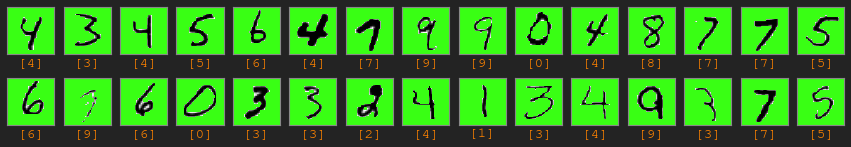

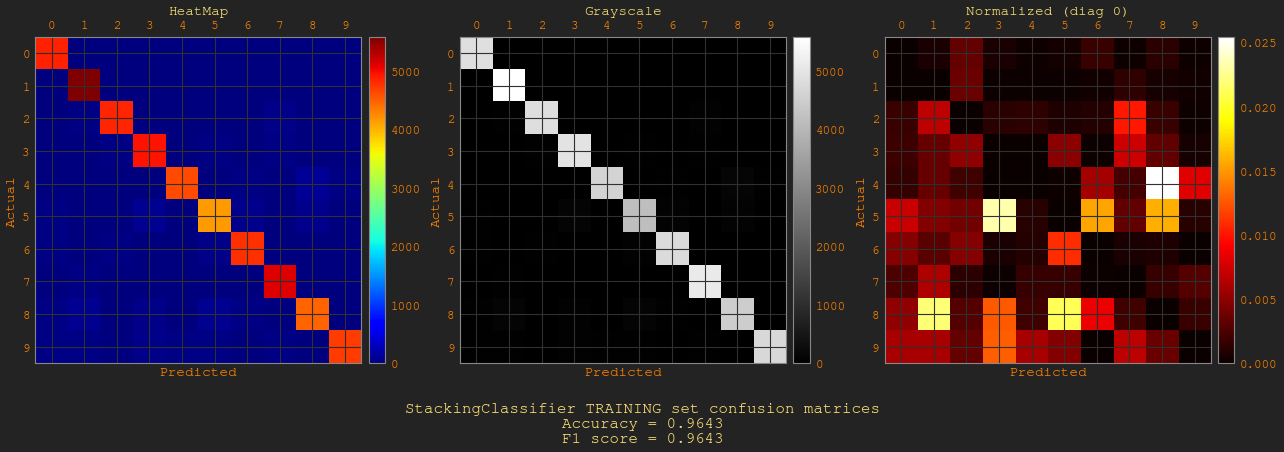

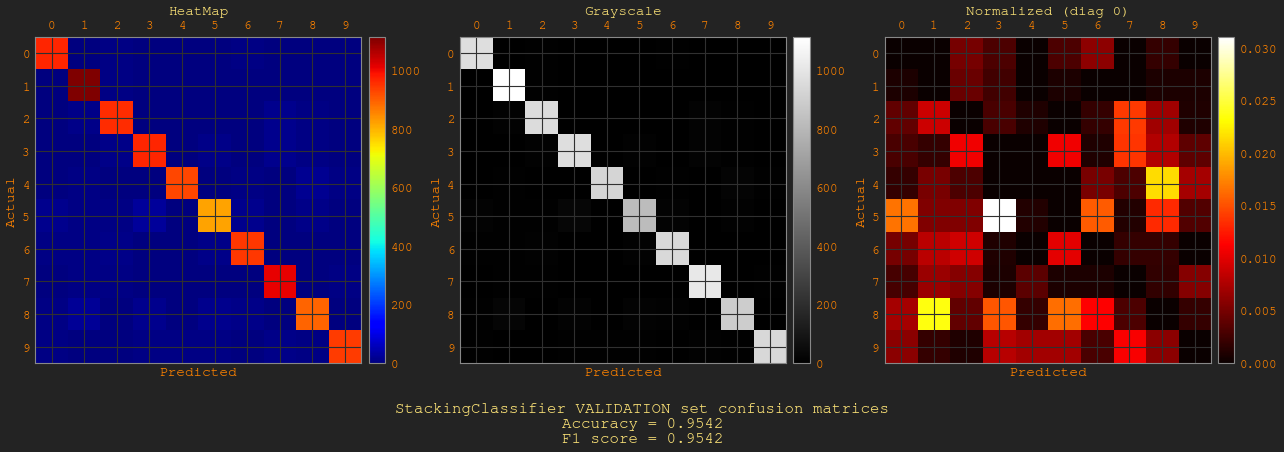

StackingClassifier(blender=RandomForestClassifier(max_depth=15,
                                                  max_leaf_nodes=399,
                                                  min_samples_leaf=271,
                                                  n_estimators=456,
                                                  random_state=42),
                   layered_predictors=[{'ext': ExtraTreesClassifier(max_depth=14,
                                                                    max_leaf_nodes=602,
                                                                    min_samples_leaf=114,
                                                                    n_estimators=253,
                                                                    random_state=0),
                                        'linsv': LinearSVC(C=0.1, loss='hinge',
                                                           random_state=2),
                                        'sftmx': LogisticRegression(C=0

In [67]:
evaluate(mnist_stack_clf, False)

# PCA

In [10]:
from sklearn.decomposition import PCA

In [11]:
d_pca = PCA(n_components = 0.95)
mnist_dpca_X_train = d_pca.fit_transform(mnist_X_train)
mnist_dpca_X_test = d_pca.transform(mnist_X_test)
print('X reduced shape  = ', mnist_dpca_X_train.shape)

X reduced shape  =  (60000, 154)


In [12]:
mnist_dpca_X_train_recovered = d_pca.inverse_transform(mnist_dpca_X_train)

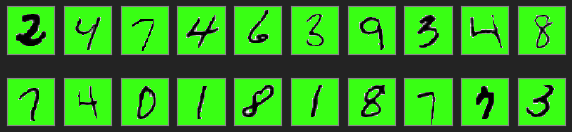

In [126]:
Show_MNIST_digits(mnist_X_train, rows = 2, randomize = True)

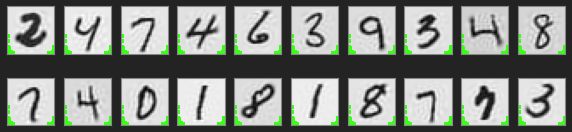

In [127]:
Show_MNIST_digits(mnist_dpca_X_train_recovered, rows = 2, randomize = True)

In [90]:
# Fit the best classifier
rndf_clf_old = RandomForestClassifier(n_estimators = 500, max_depth = 15, n_jobs = -1, random_state = 42)
%time rndf_clf_old.fit(mnist_X_train, mnist_y_train)

CPU times: user 5min 19s, sys: 1.57 s, total: 5min 20s
Wall time: 1min 4s


RandomForestClassifier(max_depth=15, n_estimators=500, n_jobs=-1,
                       random_state=42)

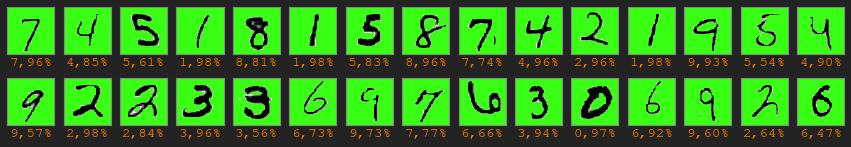

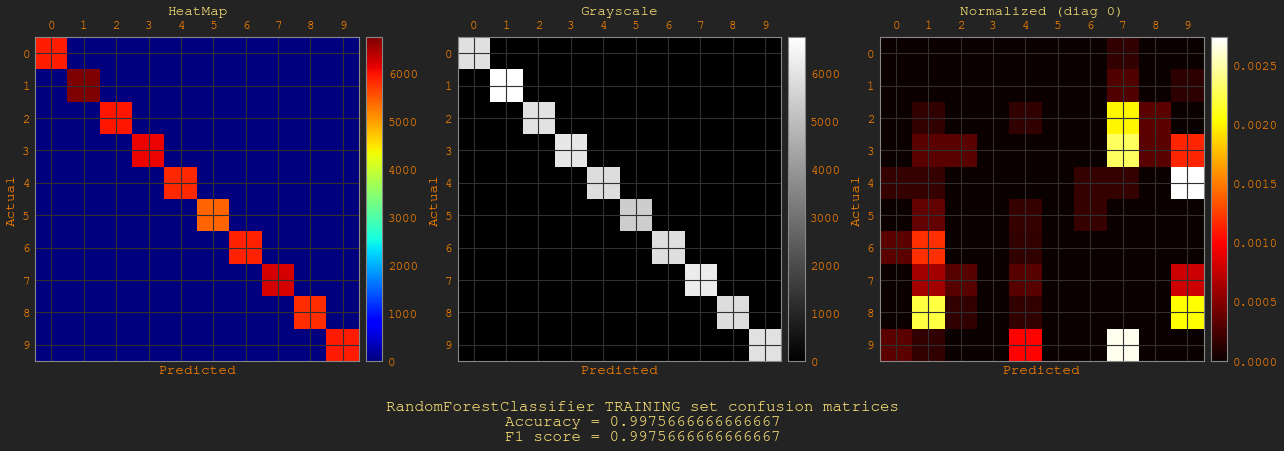

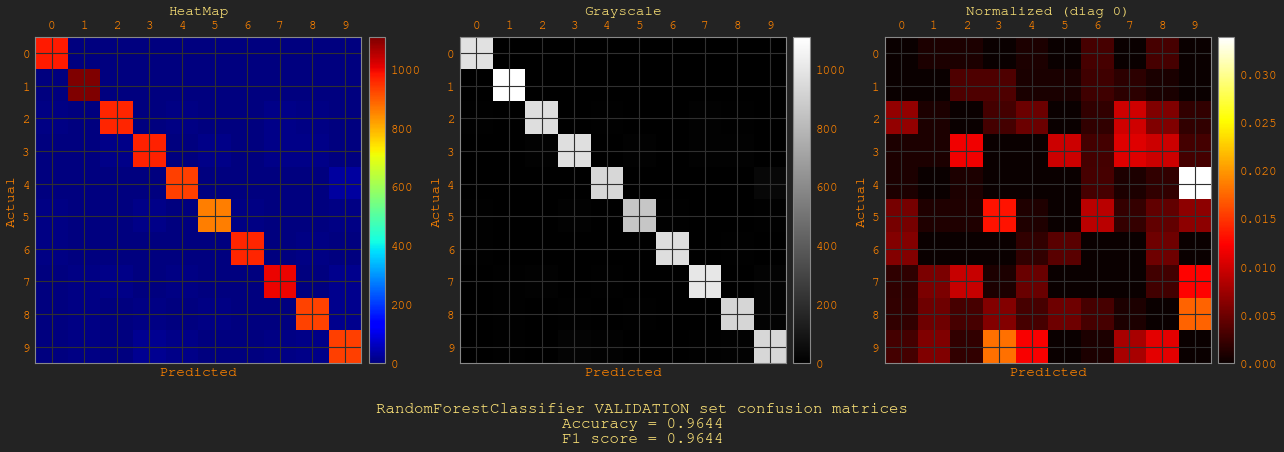

RandomForestClassifier(max_depth=15, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [116]:
evaluate(rndf_clf_old, True, mnist_X_train, mnist_X_test)

In [117]:
# Fit the same Random forest classifier as before
rndf_clf_pca = RandomForestClassifier(n_estimators = 500, max_depth = 15, n_jobs = -1, random_state = 42)
%time rndf_clf_pca.fit(mnist_dpca_X_train, mnist_y_train)

CPU times: user 6min 35s, sys: 2.07 s, total: 6min 37s
Wall time: 53.4 s


RandomForestClassifier(max_depth=15, n_estimators=500, n_jobs=-1,
                       random_state=42)

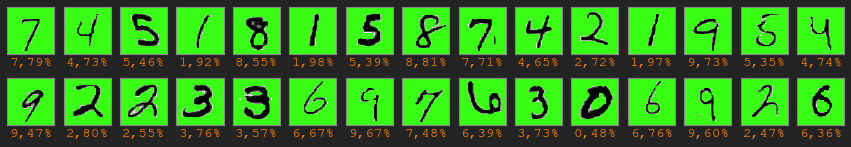

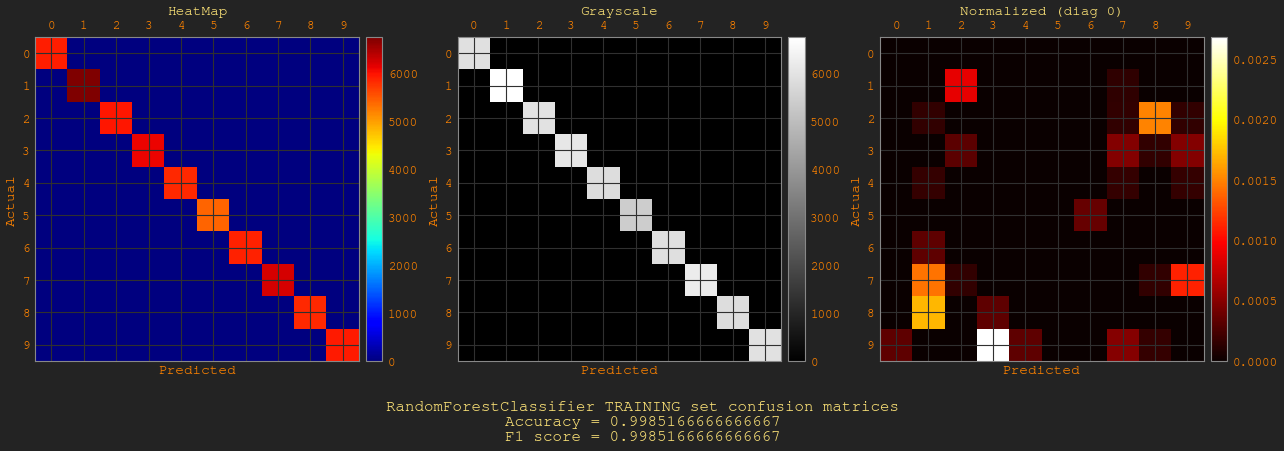

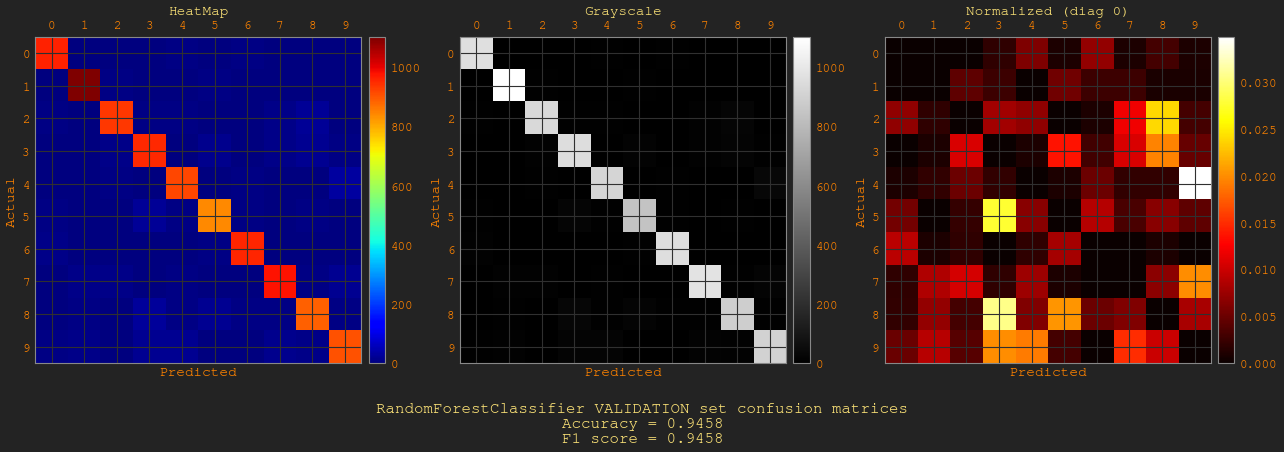

RandomForestClassifier(max_depth=15, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [118]:
evaluate(rndf_clf_pca, True, mnist_dpca_X_train, mnist_dpca_X_test)

# t-SNE

In [13]:
from sklearn.manifold import TSNE

In [25]:
tsne = TSNE(n_components = 3)
# Create a random sample
rand_sample = np.random.choice(mnist_X_train.shape[0], 
                               10000, replace=False)
X_rand_sample = mnist_X_train[rand_sample, : ]
y_rand_sample = mnist_y_train[rand_sample]

mnist_tsne_X = tsne.fit_transform(X_rand_sample)
print('X reduced shape  = ', mnist_tsne_X.shape)

X reduced shape  =  (10000, 3)


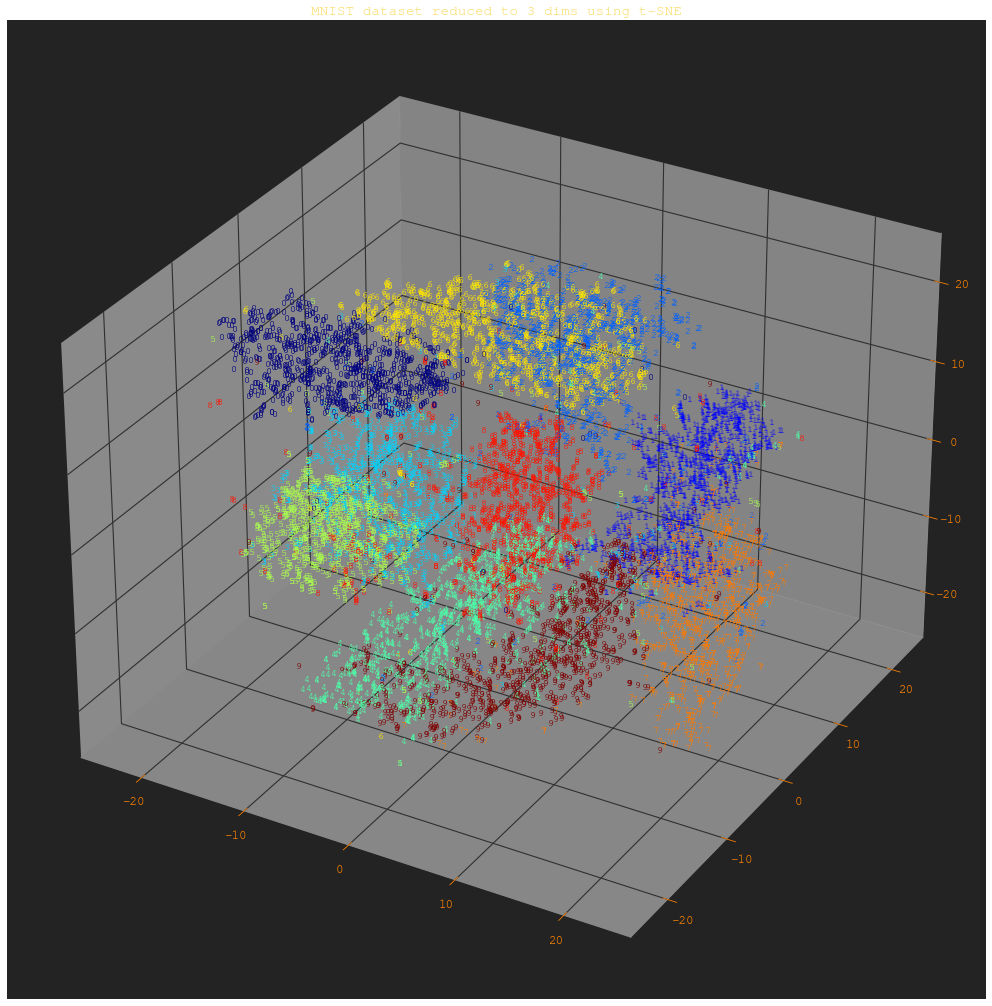

In [52]:
%matplotlib inline
from mpl_toolkits import mplot3d
from matplotlib.colors import ListedColormap
from matplotlib import cm

fig = plt.figure(figsize = (18, 18))
  
ax = plt.axes(projection ='3d')

cmap = cm.get_cmap('jet')

x_coords = mnist_tsne_X[:, 0]
y_coords = mnist_tsne_X[:, 1]
z_coords = mnist_tsne_X[:, 2]
for x, y, z, i in zip(x_coords, y_coords, z_coords, y_rand_sample):
    ax.text(x, y, z, str(i), color = cmap(i / 9.0))

#ax.scatter(x_coords, y_coords, z_coords, 
                   #color = cmap(y_rand_sample / 9.0))

ax.set_xlim(-25, 25) 
ax.set_ylim(-25, 25) 
ax.set_zlim(-25, 25) 

ax.set_title('MNIST dataset reduced to 3 dims using t-SNE')

plt.show()

In [ ]:
fig = plt.figure(figsize = (15, 15))
for x, y, i in zip(x_coords, y_coords, y_rand_sample):
    plt.text(x, y, str(i), color = cmap(i / 9.0))
plt.scatter(x_coords, y_coords, color = cmap(y_rand_sample / 9.0))
plt.axis('off')
plt.show()